In [174]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score
import re
import sweetviz as sv
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import plotly

import pytz
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from torchtext.data.utils import get_tokenizer

import optuna

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(6850)
np.random.seed(6850)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA

# Univariate Analysis

In [175]:
data = pd.read_csv('review_train.csv')
analyze_report = sv.analyze(data)
analyze_report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [176]:
data['review_timestamp']=pd.to_datetime(data['review_timestamp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13762 entries, 0 to 13761
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   review_id                   13762 non-null  int64         
 1   user_name                   13762 non-null  object        
 2   airline_sentiment           13762 non-null  object        
 3   sentiment_confidence        13762 non-null  float64       
 4   negative_reason             8627 non-null   object        
 5   negative_reason_confidence  9889 non-null   float64       
 6   airline_name                13762 non-null  object        
 7   review_text                 13762 non-null  object        
 8   thumbup_count               13762 non-null  int64         
 9   review_coordinates          972 non-null    object        
 10  review_timestamp            13762 non-null  datetime64[ns]
 11  review_city                 9314 non-null   object    

In [177]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [178]:
stopword = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopword, background_color="white", width=800, height=400,max_words=200).generate(''.join(data['review_text']))
wordcloud1 = WordCloud(stopwords=stopword, background_color="white", width=800, height=400,max_words=200).generate(''.join(data[data['airline_sentiment']=='negative']['review_text']))
wordcloud2 = WordCloud(stopwords=stopword, background_color="white", width=800, height=400,max_words=200).generate(''.join(data[data['airline_sentiment']=='positive']['review_text']))
wordcloud3 = WordCloud(stopwords=stopword, background_color="white", width=800, height=400,max_words=200).generate(''.join(data[data['airline_sentiment']=='neutral']['review_text']))

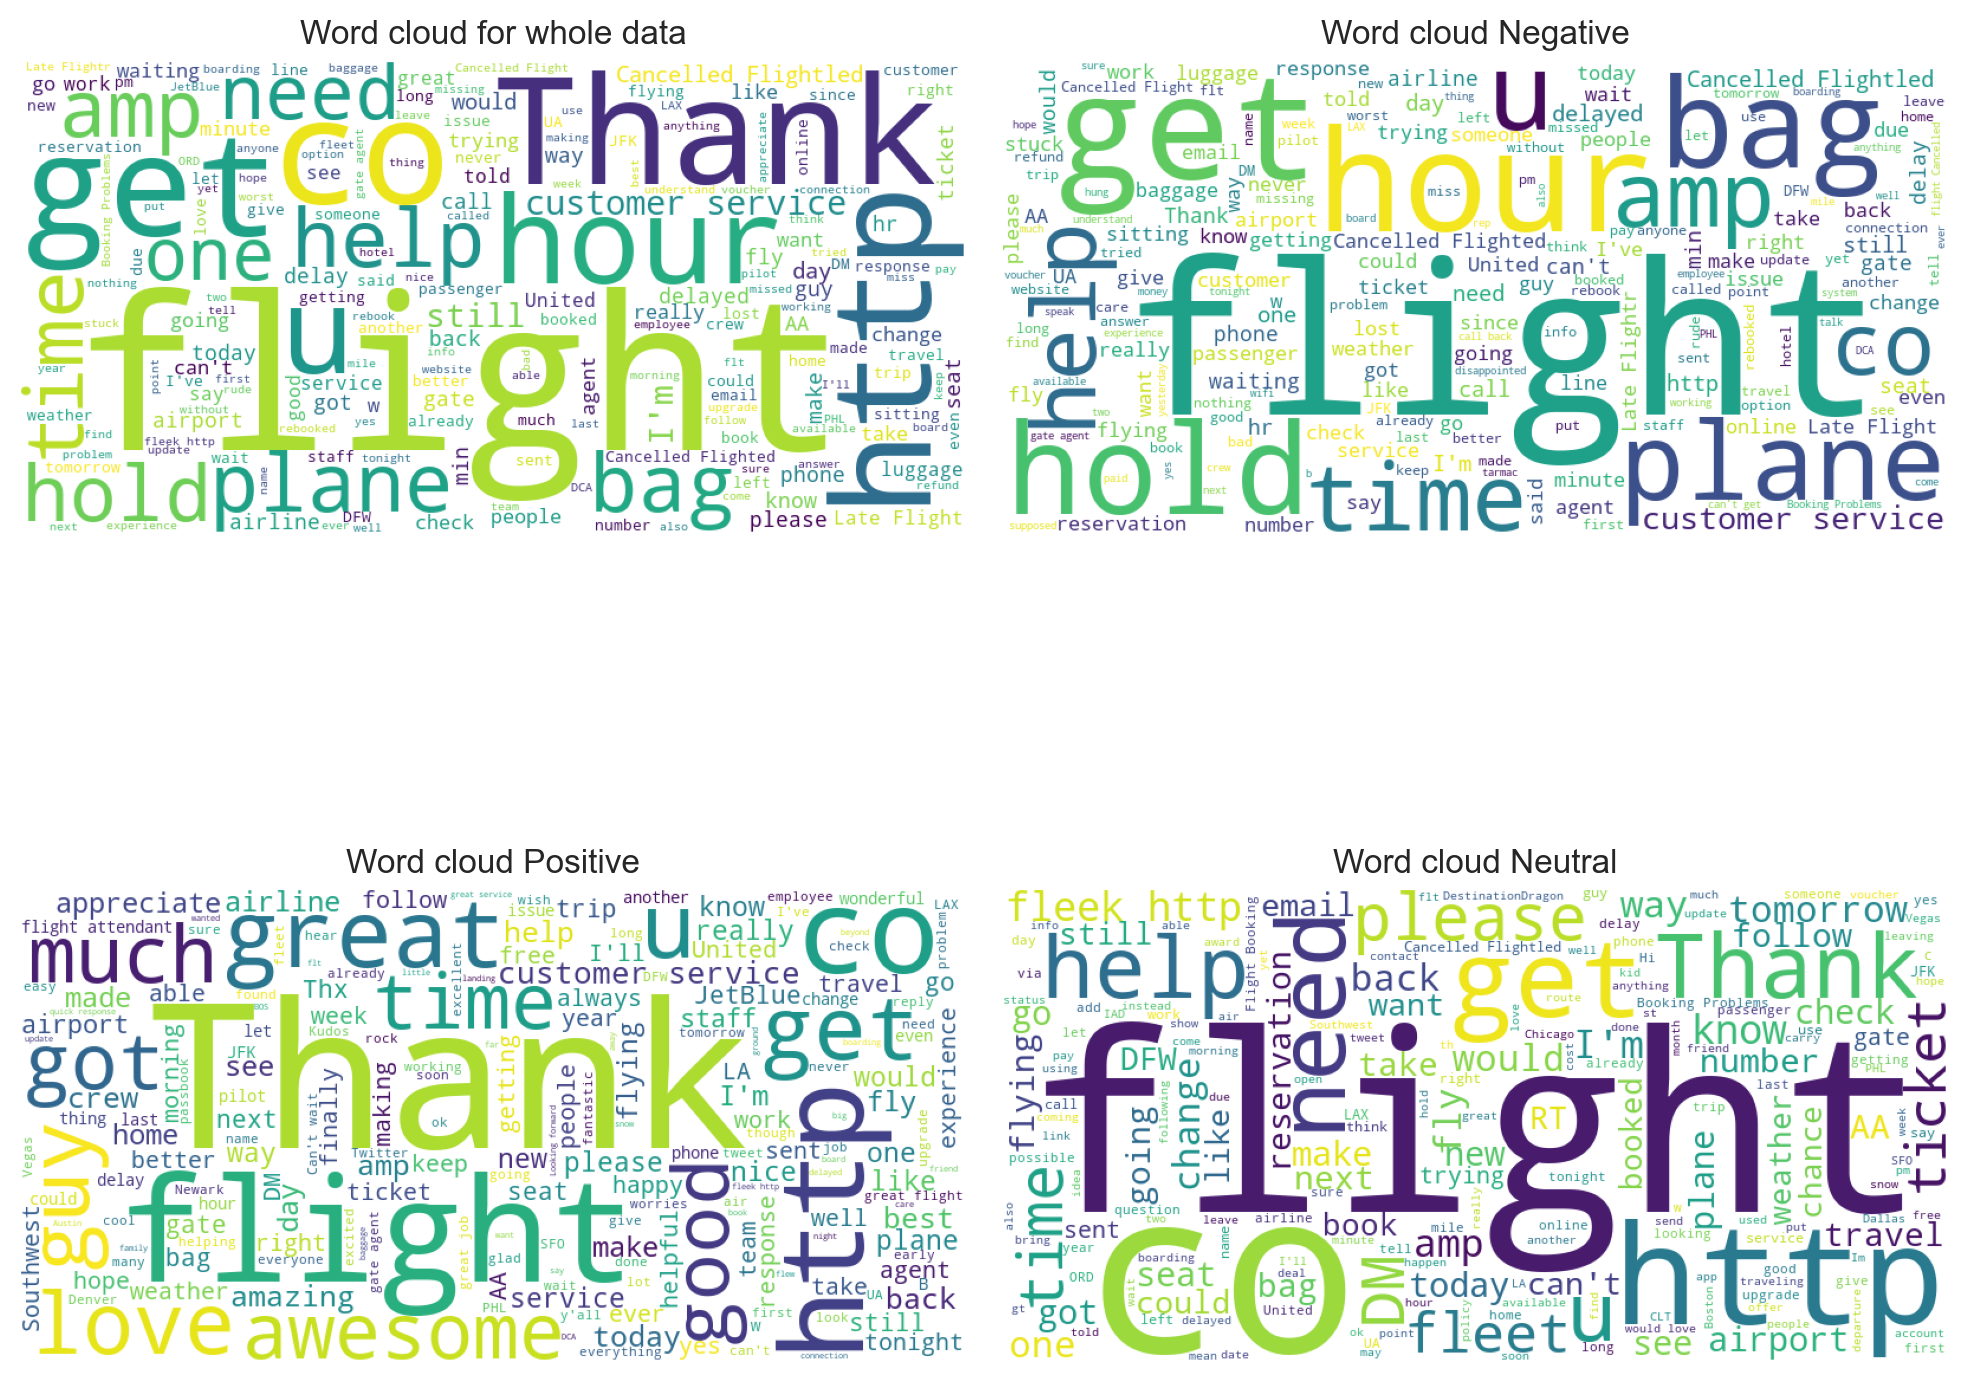

In [179]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)
axs[0, 0].imshow(wordcloud)
axs[0, 0].set_title("Word cloud for whole data")
axs[0, 0].axis("off")

axs[0, 1].imshow(wordcloud1)
axs[0, 1].set_title("Word cloud Negative")
axs[0, 1].axis("off")

axs[1, 0].imshow(wordcloud2)
axs[1, 0].set_title("Word cloud Positive")
axs[1, 0].axis("off")

axs[1, 1].imshow(wordcloud3)
axs[1, 1].set_title("Word cloud Neutral")
axs[1, 1].axis("off")
plt.show()

### Duplicated values <br>
from the initial analysis we can see review_id is not a unqiue key. We want to investigate further whether these are duplicates.

In [180]:
data[data["review_id"]==570286841737318400]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
11230,570286841737318400,djjohnpayne,negative,1.0,Cancelled Flight,0.6304,Qantas,you guys are killing me. http://t.co/iPGeIcSm,0,"[0.0, 0.0]",2015-02-24 10:19:00,"Las Vegas, NV",Pacific Time (US & Canada)
11384,570286841737318400,djjohnpayne,negative,1.0,Cancelled Flight,1.0000,Qantas,you guys are killing me. http://t.co/iPGeIcSm,0,"[0.0, 0.0]",2015-02-24 10:19:00,"Las Vegas, NV",Pacific Time (US & Canada)


In [181]:
data[data["review_id"]==570267562623152128]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
11298,570267562623152128,alinaxkristin,negative,1.0,Flight Attendant Complaints,1.0000,Qantas,you could train your flight attendants to have...,0,NaN,2015-02-24 09:02:00,Miami,Quito
11453,570267562623152128,alinaxkristin,negative,1.0,Flight Attendant Complaints,0.6688,Qantas,you could train your flight attendants to have...,0,NaN,2015-02-24 09:02:00,Miami,Quito


In [182]:
data = data.drop_duplicates(subset=['review_id'], keep='last').reset_index(drop=True)

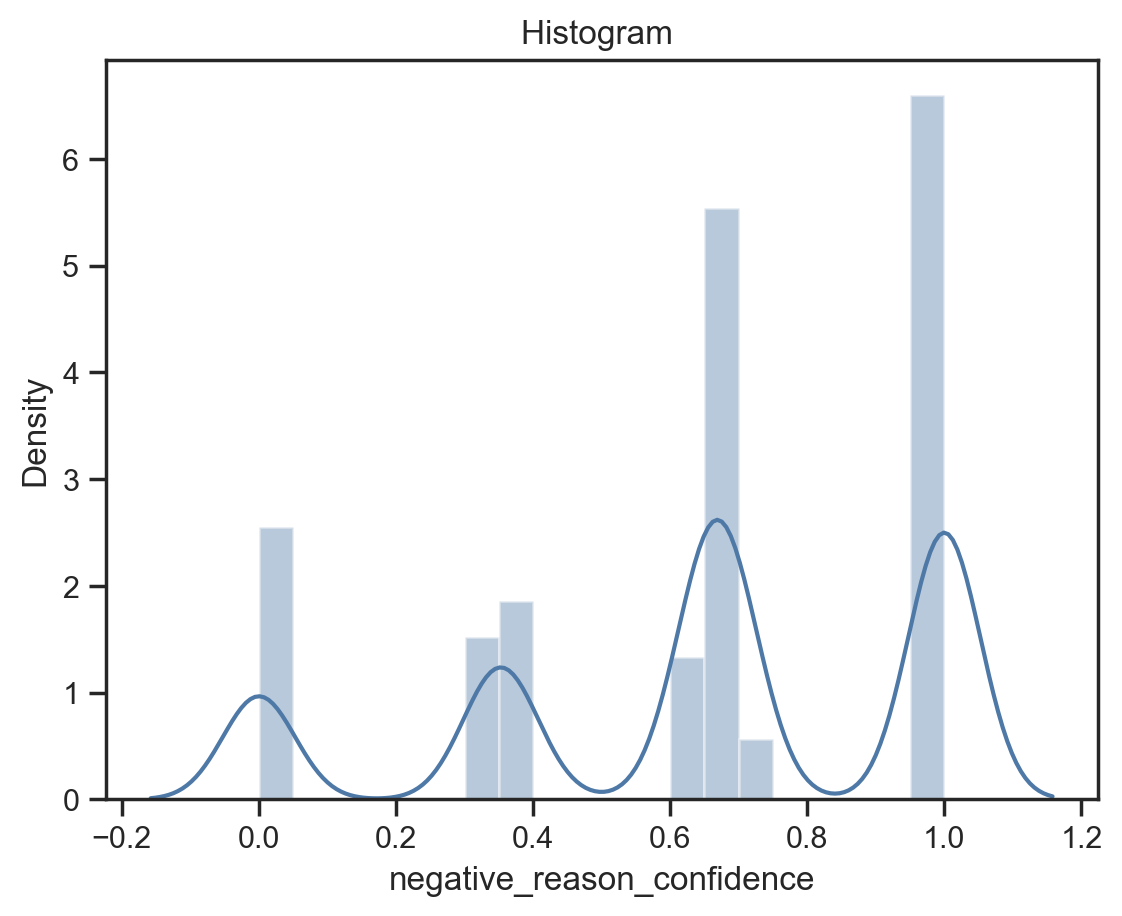

In [183]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=data["negative_reason_confidence"], bins=20)
plt.show()

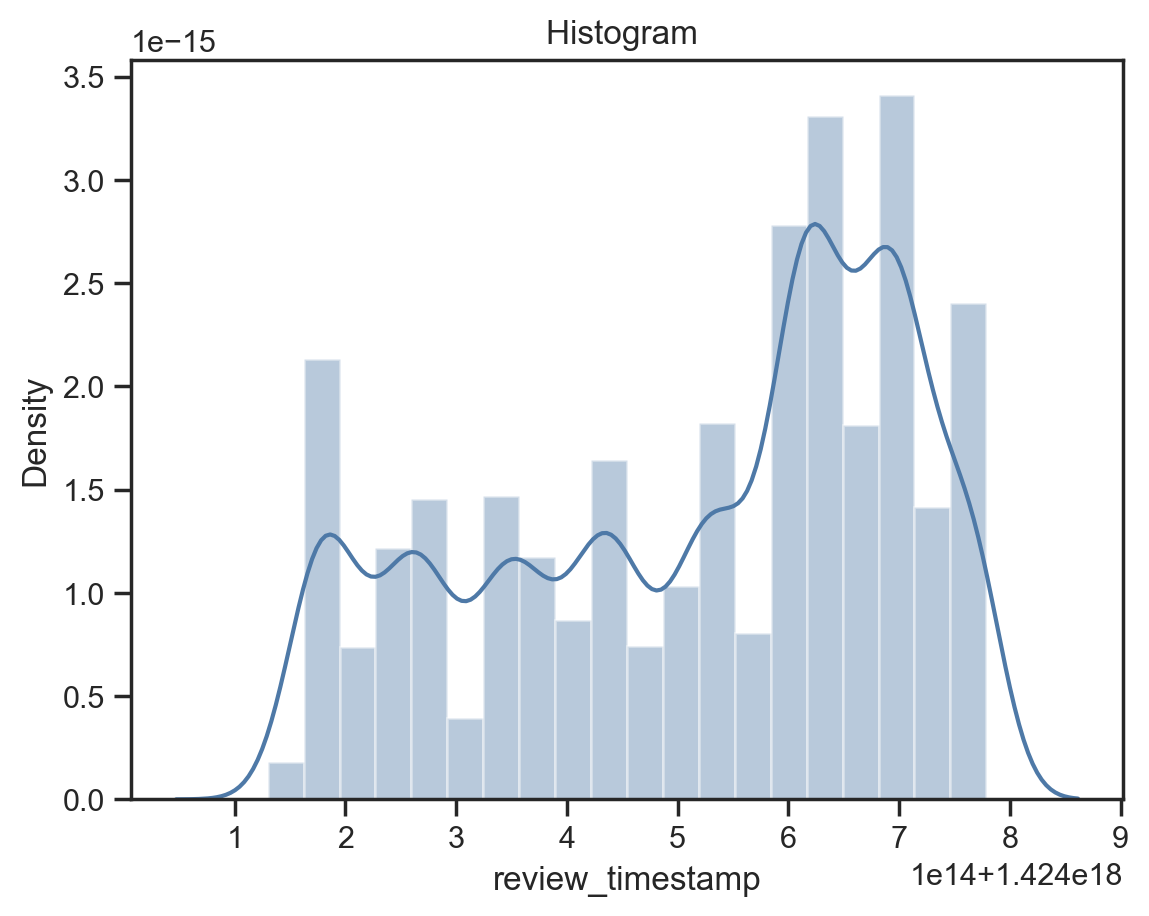

In [184]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=data["review_timestamp"], bins=20)
plt.show()

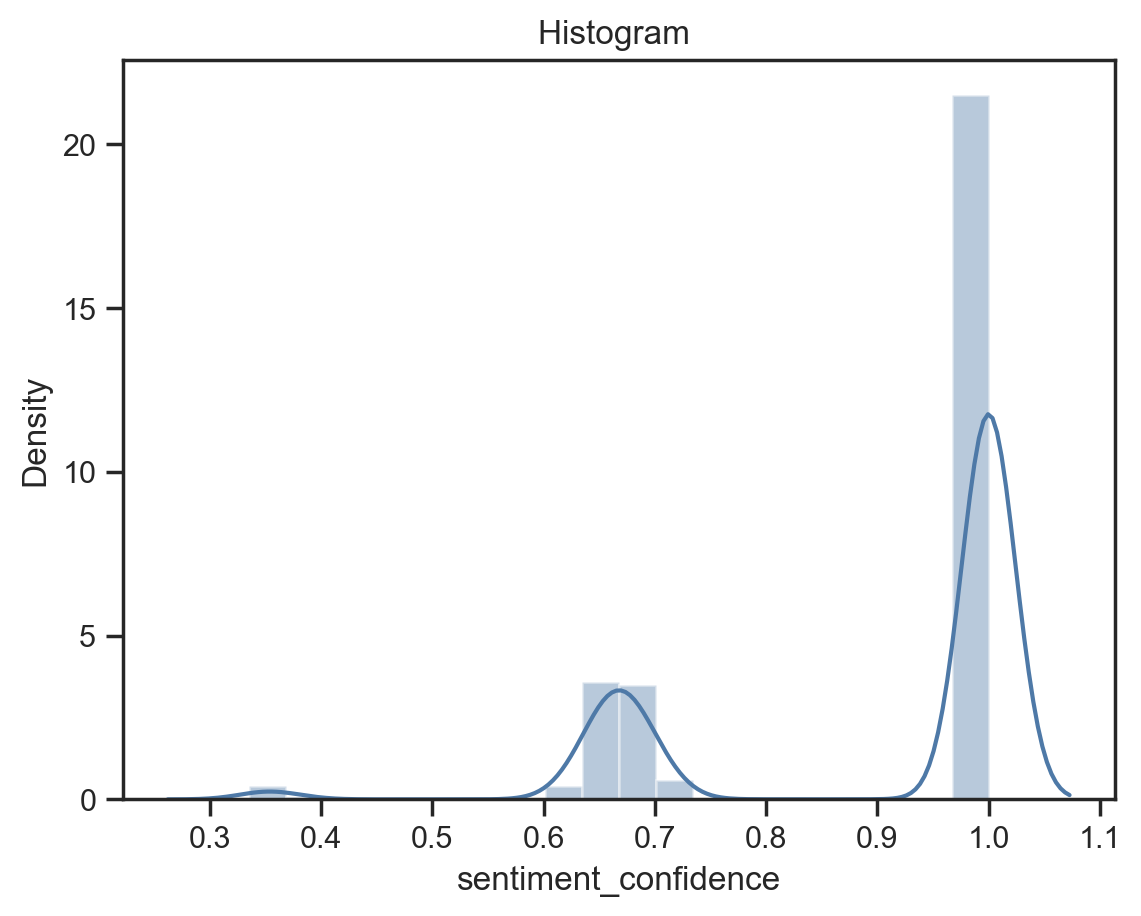

In [185]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=data["sentiment_confidence"], bins=20)
plt.show()

In [186]:
filtered_data_number = data[data['user_name'].str.contains(r'\d', regex=True, na=False)]

In [187]:
data[data['review_city']=='Does it really matter']

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
8745,569985288992264192,ElmiraBudMan,negative,1.0000,Customer Service Issue,0.3561,Qatar Airways,PLANS CHANGED! IS THAT WHAT U CALL NOT BEIN AB...,0,NaN,2015-02-23 14:20:00,Does it really matter,NaN
8769,569972250385862656,ElmiraBudMan,negative,1.0000,Lost Luggage,0.6723,Qatar Airways,only happened because u couldn't get us home t...,0,NaN,2015-02-23 13:29:00,Does it really matter,NaN
8771,569971542538346496,ElmiraBudMan,negative,0.6902,Can't Tell,0.6902,Qatar Airways,the exhaustion of traveling n runnin thru the ...,0,NaN,2015-02-23 13:26:00,Does it really matter,NaN
8777,569970626057801728,ElmiraBudMan,neutral,0.7010,NaN,0.0000,Qatar Airways,doesn't take into account the $ it cost rent a...,0,NaN,2015-02-23 13:22:00,Does it really matter,NaN
8783,569969714245431296,ElmiraBudMan,negative,1.0000,Flight Attendant Complaints,0.6736,Qatar Airways,we had a friend there telling the gate attenda...,0,NaN,2015-02-23 13:19:00,Does it really matter,NaN
8791,569968609440563201,ElmiraBudMan,negative,1.0000,Cancelled Flight,1.0000,Qatar Airways,is okay for u Cancelled Flight change a flight...,0,NaN,2015-02-23 13:14:00,Does it really matter,NaN
8794,569967808446009345,ElmiraBudMan,negative,1.0000,Customer Service Issue,0.6805,Qatar Airways,if you actually cared about what you did it wo...,0,NaN,2015-02-23 13:11:00,Does it really matter,NaN
8795,569967469135142914,ElmiraBudMan,negative,1.0000,Late Flight,0.3681,Qatar Airways,you idiots kept an on time plane on the Tarmac...,0,NaN,2015-02-23 13:10:00,Does it really matter,NaN
8805,569960904852312064,ElmiraBudMan,negative,1.0000,Customer Service Issue,1.0000,Qatar Airways,just an FYI I'll be writing registered letters...,0,NaN,2015-02-23 12:44:00,Does it really matter,NaN
8809,569959975566467072,ElmiraBudMan,negative,1.0000,Customer Service Issue,1.0000,Qatar Airways,I find it funny that responds but you don't. Y...,0,NaN,2015-02-23 12:40:00,Does it really matter,NaN


In [188]:
user_to_city_mapping = data[data['user_timezone'] != ''].groupby('user_name')['user_timezone'].first()

# Fill in the empty review_city values using the mapping
data['user_timezone'] = data.apply(
    lambda row: user_to_city_mapping.get(row['user_name'], row['user_timezone']),
    axis=1
)

In [189]:
data[data['user_name']=="somekidnamedjon"]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
8336,567776348828360707,somekidnamedjon,positive,0.6485,NaN,NaN,Singapore Airlines,I would love for you to fly my best friend hom...,0,NaN,2015-02-17 12:03:00,✈️✈️,Eastern Time (US & Canada)


we need to identify spams and elimination of data that attribute nothing to the sentimente analysis:<br>
we found that news and user spams are both included in the database. 
In the mean time we also don't see much values in the timezone. As user time zone does not impact sentiment of their 
Therefore, we decide to not include that column too. 

We would also get ride off the he thumb_up data as it contains a 94% zero value.

### Bivariate Analysis 

In [190]:
data['review'] = data.apply(lambda row: row['negative_reason'] if not pd.isna(row['negative_reason']) and row['negative_reason'] != '' else row['airline_sentiment'], axis=1)
pd.crosstab(data['airline_name'], data['review'])

review,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines,neutral,positive
airline_name,,,,,,,,,,,,
EgyptAir,18,21,17,57,4,5,27,16,3,1,155,142
Emirates,208,351,166,637,20,156,132,492,261,46,660,465
Lufthansa,82,152,149,367,13,37,60,146,87,27,623,537
Qantas,78,180,218,692,11,76,119,224,136,31,401,291
Qatar Airways,97,228,175,773,10,118,116,425,143,47,361,256
Singapore Airlines,59,172,49,181,8,58,41,255,52,14,677,508


In [191]:
debug_selection = len(data[(data['negative_reason_confidence'].isna()) & (data['airline_sentiment'] == 'negative')])
print(debug_selection)

0


From the above EDA extracts we can see: <br>
1. The airline sentiment are separated into 3 different kinds with 63% in negative, 21% in neural, and 16% in positive.<br>
2. There are 10 negative reasons, and the top 1 accounts for 32% being: Customer service Issue.<br>
3. We can see the data is collected from 6 different airline companies, with the top 3 being Emirate (26%), Qatar Airways(20%), and Qantas (19%)<br>

<br>
The data is suffering from missing data:<br>

1. 92.24% of review coordinates are missing, we this varible is going to cause collinearity issue with review city and we decide to keep review city. <br>

2. Contrary to our believe,review city and user time zone do not share all its missing rows. Only 2499 rows are missing for both review city and review time_zone. The inclusion of review coordinate can bring this down to 2418.<br>

3. The missing values of negative_reason is caused by the airline_sentiment not being negative. we are going to create a new column called reivew and backfill " positive" or "neural" for the missing values.


Due to the frequent apperance of unformted and incorrect entries, we are unable to use review city and decide to remove that one.
Due to the huge amount of missing data for the review coordianate. we decide to remove this column too.

# Preprocessing and feature engineering

In [192]:
data['response'] = data['airline_sentiment'].replace({'negative': 2, 'neutral': 1, 'positive': 0})
data['response'].value_counts()

response
2    8544
1    2877
0    2199
Name: count, dtype: int64

In [193]:
# Remove URLs from text
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

def add_flag(row):
    if row['has_neg_reason']:
        row['review_text_flagged'] += ' @hasnegreason'
    return row

In [194]:
data['review_text'] = data['review_text'].apply(remove_URL)
data['has_neg_reason'] = (~data['negative_reason'].isna()).astype(int)
data['review_text_flagged'] = data['review_text'].values
data = data.apply(add_flag, axis=1)

In [195]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [196]:
def process_reviews(train_reviews):
    # pre-processing review_text
    processed_train_reviews = []
    processed_sentences = []
    for review in train_reviews:
        # to lower case
        review = review.lower()
        words = nltk.word_tokenize(review, language="english")
        # remove stop words
        words = [word for word in words if word not in stop_words]
        # remove puntuation
        words = [re.sub("[^A-Za-z']+", '', str(word)) for word in words]
        words = [lemmatizer.lemmatize(word) for word in words]
        words = [word for word in words if word]
        # to string
        sentence = ' '.join(words)
        processed_train_reviews.append(words)
        processed_sentences.append(sentence)
    return processed_train_reviews, processed_sentences

tokenized_text, processed_sentences = process_reviews(data['review_text'])
data['review_text_processed'] = processed_sentences
lengths = [len(s) for s in tokenized_text]
data['review_length'] = lengths

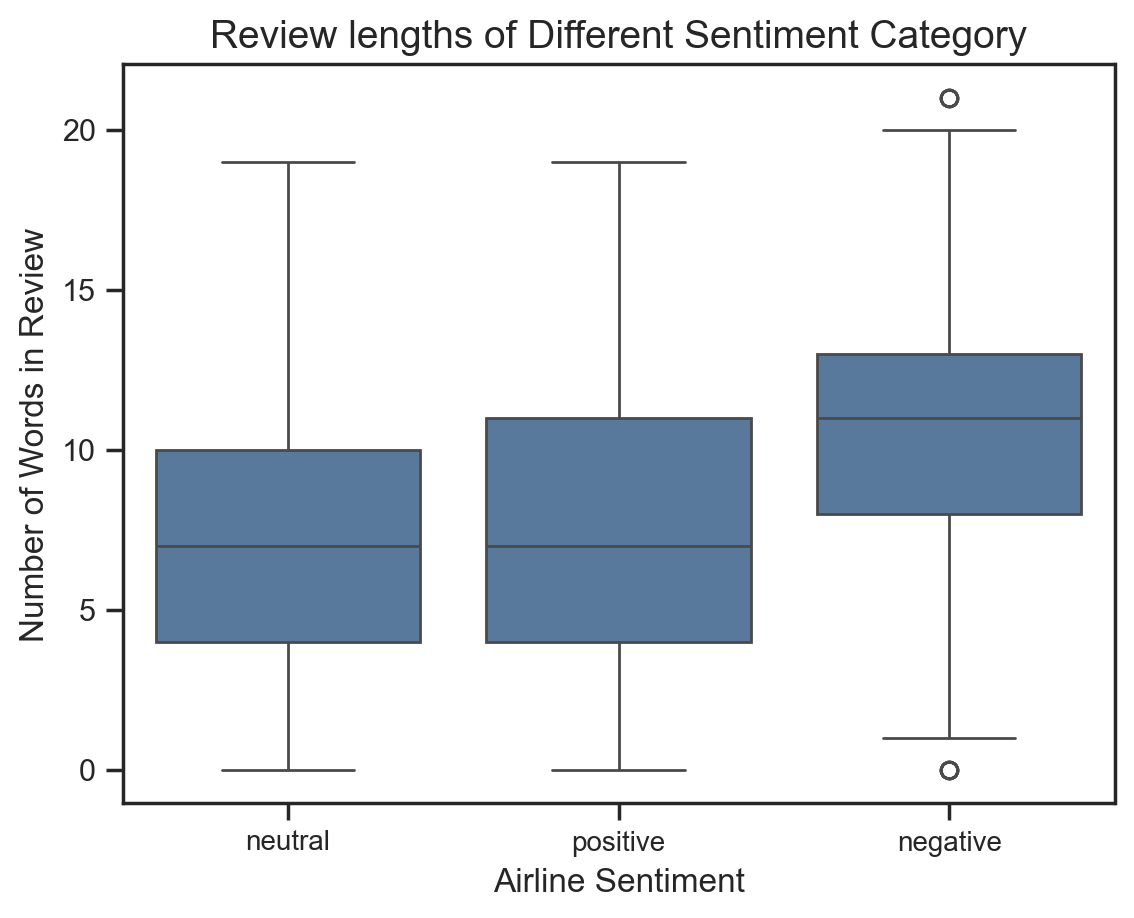

In [197]:
sns.boxplot(data, x='airline_sentiment', y='review_length')
plt.xlabel('Airline Sentiment')
plt.xticks(fontsize=10)
plt.ylabel('Number of Words in Review')
plt.title('Review lengths of Different Sentiment Category', fontsize=14)
plt.savefig('review_length', dpi=800)

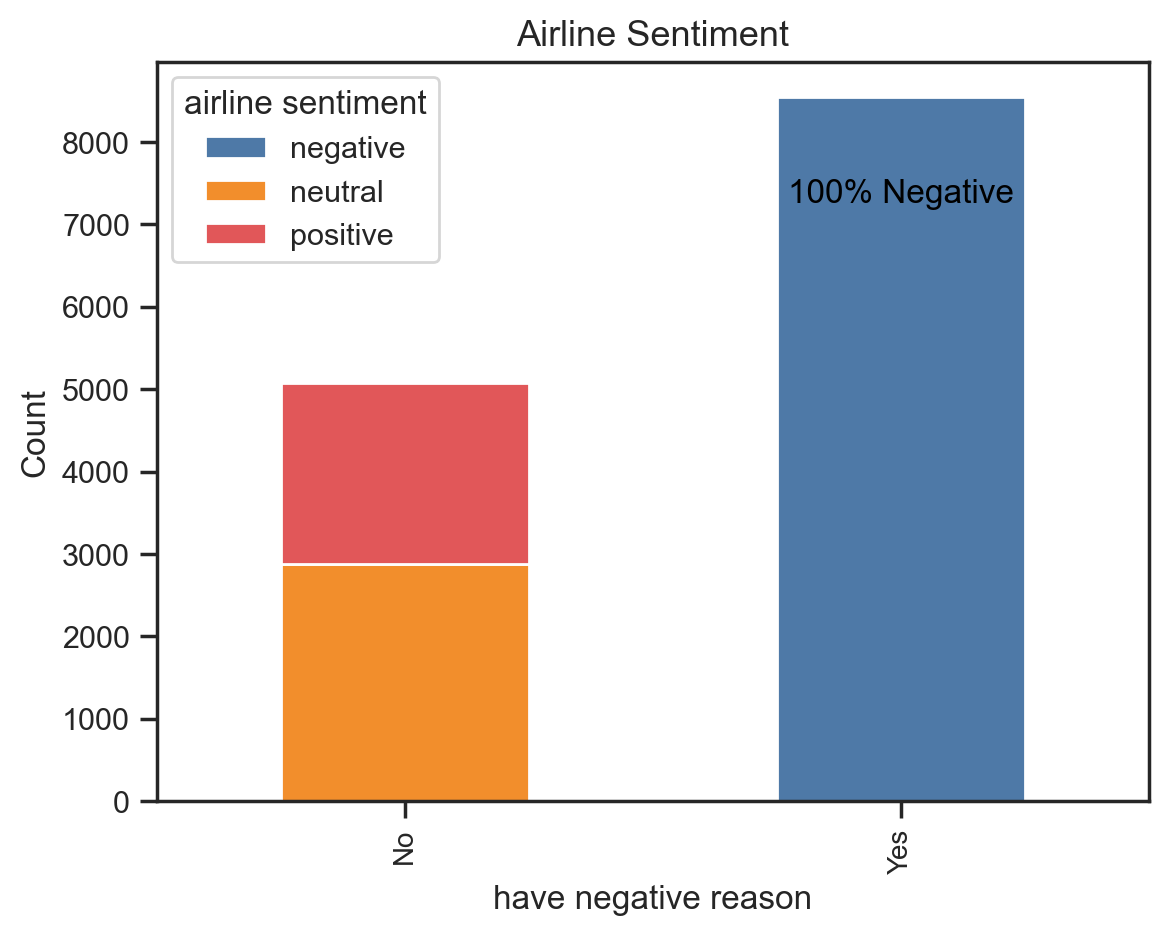

In [198]:
counts = pd.crosstab(data['airline_sentiment'], data['has_neg_reason']).T
ax = counts.plot(kind='bar', stacked=True)
plt.title('Airline Sentiment', fontsize=13)
plt.xlabel('have negative reason')
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'], fontsize=10)
plt.legend(title='airline sentiment')
ax.annotate(f'\n100% Negative', (1, 8000), ha='center', va='top', color='black', size=12)
plt.savefig('haveneg.png', dpi=300)

In [199]:
from sklearn.model_selection import train_test_split

index_train_vali, index_test = train_test_split(data.index, train_size=0.9, random_state=6850, stratify=data['response'])
index_train, index_vali = train_test_split(index_train_vali, train_size=8/9, random_state=6850, stratify=data.loc[index_train_vali, :]['response'])

data_train = data.loc[index_train, :].copy()
data_train_vali = data.loc[index_train_vali, :].copy()
data_vali = data.loc[index_vali, :].copy()
data_test = data.loc[index_test, :].copy()

In [200]:
tokenizer = get_tokenizer('basic_english')
vocabulary = build_vocab_from_iterator(
    [tokenizer(msg) for msg in data_train_vali['review_text_processed']],
    specials=["<unk>"],
    min_freq = 3, # filter out all words that appear less than three times
)
# Set to avoid errors with unknown words
vocabulary.set_default_index(vocabulary["<unk>"])

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(norm='l2', smooth_idf=True, vocabulary=vocabulary.get_stoi(), tokenizer=tokenizer)
tfidf_train = vectorizer.fit_transform(data_train_vali['review_text_processed'])

In [202]:
X_train_boosting = np.concatenate((tfidf_train.toarray(), data_train_vali[['review_length']].values), axis=1)
y_train_boosting = data_train_vali['response']

# Xgboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

xgbst =xgb.XGBClassifier(objective='multi:softmax',
                       num_class=3,
                      eval_metric='mlogloss',
                      randomstate=42,
                      verbosity=1)

tuning_parameters={
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[2,3,4,5,6,7],
    'n_estimators':[800,1000,1500,2000],
    'subsample':[0.60,0.80,1.0],
    'reg_lambda':[0.0,0.3,0.5,0.8]
}

xgbst_random = RandomizedSearchCV(xgbst, 
                                  tuning_parameters,
                                  n_iter=16,
                                  cv=5, 
                                 random_state=42,
                                 n_jobs=-2)
xgbst_random.fit(X_train_boosting,y_train_boosting)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=3, num_parallel_tree=None, ...),
                   n_iter=16, n_jobs=-2,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'n_estimators': [800, 1000, 1500, 2000],
                                        'reg_lambda': [0.0, 0.3, 0.5, 0.8],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42)

In [ ]:
print('Best parameters found by randomized search:', xgbst_random.best_params_)
xgbst_update=xgb.XGBClassifier(objective='multi:softmax',
                              num_class=3,
                              eval_metric='mlogloss',
                              **xgbst_random.best_params_)
xgbst_update.fit(X_train_boosting,y_train_boosting)

Best parameters found by randomized search: {'subsample': 0.8, 'reg_lambda': 0.8, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.1}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [ ]:
tfidf_test = vectorizer.fit_transform(data_test['review_text_processed'])
X_test_boosting = np.concatenate((tfidf_test.toarray(), data_test[['review_length']].values), axis=1)
y_test_boosting = data_test['response']
y_pred_boost, y_pred_proba_boost = xgbst_update.predict(X_test_boosting), xgbst_update.predict_proba(X_test_boosting)
print(classification_report(y_test_boosting, y_pred_boost))
print('test set cross entropy loss:', log_loss(y_test_boosting, y_pred_proba_boost))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67       220
           1       0.64      0.49      0.55       288
           2       0.81      0.90      0.86       854

    accuracy                           0.77      1362
   macro avg       0.72      0.67      0.69      1362
weighted avg       0.76      0.77      0.76      1362

test set cross entropy loss: 0.5596252919605451


# Task C: vanilla RNN

In [213]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

class RnnDataset(utils.data.Dataset):
    def __init__(self, myData):
        """
        myData should be a dataframe object containing both y (first col) and X (second col)
        """
        super().__init__()
        self.data = myData
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return (self.data.iloc[idx,0], self.data.iloc[idx,1]) # (target, text)


tokenizer = get_tokenizer('basic_english')
vocabulary = build_vocab_from_iterator(
    [tokenizer(msg) for msg in data_train['review_text_processed']],
    specials=["<unk>"],
    min_freq = 3, # filter out all words that appear less than three times
)
vocabulary.set_default_index(vocabulary["<unk>"])
vocab_size = len(vocabulary)

# now we can build our torch dataset 
train_torch = RnnDataset(data_train[['response', 'review_text_processed']])
val_torch = RnnDataset(data_vali[['response', 'review_text_processed']])
test_torch = RnnDataset(data_test[['response', 'review_text_processed']])

In [214]:
from torch.nn.utils.rnn import pad_sequence
# define a function that converts a document into tokens (represented by index)
def doc_tokenizer(doc):
    return torch.tensor([vocabulary[token] for token in tokenizer(doc)], dtype=torch.long)

def collate_batch_advanced(batch):
    
    target_list, text_list = [], []
    
    # loop through all samples in batch
    for idx in range(len(batch)):
        
        _label = batch[idx][0]
        _text = batch[idx][1]
        
        target_list.append( _label )
        tokens = doc_tokenizer( _text )
        text_list.append(tokens)
            
    # convert to torch tensor
    target_list = torch.tensor(target_list, dtype=torch.int64)
    
    return target_list, text_list

# Extract one-hot encoding vectors directly from an identity matrix
eye = torch.eye(vocab_size)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_RNNLayer, p=0.1):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_RNNLayer = num_RNNLayer
        
        # switch to embedding layer: padding_idx = 0 means we treat index=0 as padding and don't train its embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.load_state_dict({'weight': eye})
        self.embedding.weight.requires_grad = False
        
        # Here we implement a multi-layer RNN
        self.rnn = nn.RNN(input_size=embed_dim, 
                          hidden_size=hidden_dim, 
                          num_layers = num_RNNLayer, 
                          batch_first=True) 
        
        # output layer
        self.Linear1 = nn.Linear(hidden_dim, 3) 
        self.Dropout = nn.Dropout(p=p)
    
    def forward(self, x):
        # Hidden init (note the batch dimension is the second one as required)
        h = torch.zeros((self.num_RNNLayer, x.size(0), self.hidden_dim))
        torch.nn.init.xavier_normal_(h)
        
        # embedding layer 
        out = self.embedding(x)
        # rnn layer
        out, h = self.rnn(out, h)
        out = self.Dropout(out)
        # The last hidden state is taken (Batch, seq_length, dim)
        out = self.Linear1(out[:,-1,:])
        
        return out

In [217]:
torch.manual_seed(0)
test_loader = utils.data.DataLoader(test_torch, batch_size=16, shuffle=False, collate_fn=collate_batch_advanced)


#construct the training loop for hyperparameter tuning
def train_rnn(train_torch, vali_torch, num_epoch, batch_size, hidden_dim, num_RNNLayer, lr, weight_decay, embed_dim, p=0.1, patience=20, GLOVE=False, vocab_size=vocab_size):
    train_loader = utils.data.DataLoader(train_torch, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_advanced)
    val_loader = utils.data.DataLoader(vali_torch, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_advanced)

    if not GLOVE:
        model = RNNClassifier(vocab_size, embed_dim, hidden_dim, num_RNNLayer, p)
    else:
        model = RNNClassifierGLOVE(vocab_size, embed_dim, hidden_dim, num_RNNLayer, p)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    def evaluate_adv(dataloader):  
        y_pred = torch.tensor([]) # store prediction
        y_true = torch.tensor([]) # store true label        
        model.eval()
        with torch.no_grad():
            for label, text in dataloader:
                
                # we will need to pad the sequences with zero, batch_first means to organize batch size to be the first dim
                # and we use 0 to pad them to the same lengths
                text = pad_sequence(text, batch_first=True, padding_value=0)
                
                y_pred_batch = model(text)
                y_pred = torch.cat((y_pred, y_pred_batch.squeeze()))
                y_true = torch.cat((y_true, label.squeeze()))
                
        return y_pred, y_true
    
    # training
    best_val_loss = 0.0
    best_epoch = 0

    for epoch in range(num_epoch):
        for y_train, text in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # we will need to pad the sequences with zero
            text = pad_sequence(text, batch_first=True, padding_value=0)
            # calulate output and loss 
            y_pred_train = model(text)
            loss = loss_fn(y_pred_train.squeeze(), y_train.long())
            
            # backprop and take a step
            loss.backward()
            optimizer.step()
        
        # evaluate on validation set
        y_pred_val, y_val = evaluate_adv(val_loader)
        loss_val = loss_fn(y_pred_val.squeeze(), y_val.long())
        if loss_val < best_val_loss or best_val_loss == 0.0:
            best_val_loss = loss_val
            best_epoch = epoch
            torch.save(model, 'saved_best_rnn.pth')
            print('saving model...')
        elif epoch - best_epoch >= patience:
            print(f"Early stopping after {patience} epochs of no improvement.")
            break
        
        pred_label = torch.argmax(y_pred_val, axis=1) # find out the class prediction
        acc = (pred_label == y_val).float().sum()/y_val.shape[0]
        val_f1 = f1_score(y_val, pred_label, average='macro')
        model.train() # because when evaluating we change mode to eval mode
        if epoch % 5 == 0:
            print('Epoch {}: {:.4f} (train), {:.4f} (val), {:.4f} (val acc), {:.4f} (val f1)'.format(epoch, loss, loss_val, acc, val_f1))

    model = torch.load('saved_best_rnn.pth')
    return model, best_val_loss.detach().numpy()[()]


In [219]:
# Hyperparameter tuning using Optuna.
def objective(trial):
    # Define hyperparameter searching space
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64]),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32, 64]),
        'lr': trial.suggest_categorical('lr', [0.00001, 0.00003, 0.0001, 0.0003, 0.001]),
        'weight_decay': trial.suggest_categorical('weight_decay', [0, 0.01, 0.03, 0.1]),
        'num_RNNLayer': trial.suggest_categorical('num_RNNLayer', [1,]),
        'num_epoch': trial.suggest_categorical('num_epoch', [50, 100, 200]),
        'p': trial.suggest_categorical('p', [0, 0.1, 0.2]),
    }

    _, val_loss = train_rnn(train_torch, val_torch, embed_dim=vocab_size, **params)

    trial.set_user_attr('params', params)
    
    return val_loss
    
# Create an Optuna study
sampler = optuna.samplers.TPESampler(seed=6850)
pruner = optuna.pruners.HyperbandPruner(min_resource = 20, max_resource = 'auto', reduction_factor = 3)
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Optimize the objective function
study.optimize(objective, timeout=1200)

# get the best parameters
params = study.best_trial.user_attrs['params']

[I 2023-11-03 09:51:56,376] A new study created in memory with name: no-name-01406eb1-0a49-4fba-8b4f-9bfa61029ad3


saving model...
Epoch 0: 0.8519 (train), 0.7575 (val), 0.6601 (val acc), 0.4162 (val f1)
saving model...
saving model...
Epoch 5: 0.3794 (train), 0.5856 (val), 0.7717 (val acc), 0.7044 (val f1)
saving model...
Epoch 10: 0.1669 (train), 0.6332 (val), 0.7753 (val acc), 0.7164 (val f1)
Epoch 15: 0.0776 (train), 0.7100 (val), 0.7695 (val acc), 0.6962 (val f1)
Epoch 20: 0.3508 (train), 0.6988 (val), 0.7562 (val acc), 0.6854 (val f1)
Epoch 25: 0.1786 (train), 0.8133 (val), 0.7394 (val acc), 0.6777 (val f1)


[I 2023-11-03 09:52:50,466] Trial 0 finished with value: 0.5813390016555786 and parameters: {'hidden_dim': 32, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0.1, 'num_RNNLayer': 2, 'num_epoch': 50, 'p': 0.1}. Best is trial 0 with value: 0.5813390016555786.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 0.9221 (train), 0.9163 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
Epoch 5: 0.7319 (train), 0.9178 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 10: 0.9075 (train), 0.9221 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 15: 0.6246 (train), 0.9193 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 20: 0.9963 (train), 0.9212 (val), 0.6270 (val acc), 0.2569 (val f1)


[I 2023-11-03 09:55:22,856] Trial 1 finished with value: 0.9157088994979858 and parameters: {'hidden_dim': 8, 'batch_size': 8, 'lr': 0.01, 'weight_decay': 0.01, 'num_RNNLayer': 3, 'num_epoch': 200, 'p': 0.1}. Best is trial 0 with value: 0.5813390016555786.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 1.0649 (train), 0.8986 (val), 0.6468 (val acc), 0.3735 (val f1)
saving model...
Epoch 5: 0.5123 (train), 0.8406 (val), 0.6512 (val acc), 0.3628 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 10: 0.5310 (train), 0.6246 (val), 0.7482 (val acc), 0.6804 (val f1)
Epoch 15: 0.3813 (train), 0.7138 (val), 0.7276 (val acc), 0.6451 (val f1)
Epoch 20: 0.5805 (train), 0.7306 (val), 0.7438 (val acc), 0.6627 (val f1)
Epoch 25: 0.9762 (train), 0.7937 (val), 0.7482 (val acc), 0.6874 (val f1)


[I 2023-11-03 09:58:07,807] Trial 2 finished with value: 0.6246465444564819 and parameters: {'hidden_dim': 16, 'batch_size': 8, 'lr': 0.003, 'weight_decay': 0, 'num_RNNLayer': 1, 'num_epoch': 50, 'p': 0.1}. Best is trial 0 with value: 0.5813390016555786.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 0.7230 (train), 0.9178 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
Epoch 5: 0.7446 (train), 0.9204 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
Epoch 10: 0.9388 (train), 0.9169 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
Epoch 15: 0.7914 (train), 0.9177 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 20: 1.2316 (train), 0.9175 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 25: 0.8344 (train), 0.9223 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 30: 0.9996 (train), 0.9252 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
saving model...
Epoch 35: 0.9454 (train), 0.9279 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 40: 0.7607 (train), 0.9235 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 45: 1.1898 (train), 0.9167 (val), 0.6270 (val acc), 0.2569 (val f1)
Epoch 50: 1.0596 (train), 0.9165 (val), 0.6270 (val acc), 0.2569 (val f1)


[I 2023-11-03 10:00:03,616] Trial 3 finished with value: 0.9152724742889404 and parameters: {'hidden_dim': 16, 'batch_size': 64, 'lr': 0.01, 'weight_decay': 0, 'num_RNNLayer': 3, 'num_epoch': 200, 'p': 0.1}. Best is trial 0 with value: 0.5813390016555786.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 0.8278 (train), 0.7446 (val), 0.6784 (val acc), 0.5040 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.4242 (train), 0.6367 (val), 0.7416 (val acc), 0.6680 (val f1)
saving model...
Epoch 10: 0.3493 (train), 0.5951 (val), 0.7570 (val acc), 0.6929 (val f1)
Epoch 15: 0.2776 (train), 0.6236 (val), 0.7724 (val acc), 0.7075 (val f1)
Epoch 20: 0.2738 (train), 0.6381 (val), 0.7592 (val acc), 0.6921 (val f1)
Epoch 25: 0.2055 (train), 0.6667 (val), 0.7665 (val acc), 0.7013 (val f1)


[I 2023-11-03 10:02:05,749] Trial 4 finished with value: 0.5902093052864075 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'lr': 0.0001, 'weight_decay': 0, 'num_RNNLayer': 2, 'num_epoch': 50, 'p': 0.2}. Best is trial 0 with value: 0.5813390016555786.


Early stopping after 20 epochs of no improvement.


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [223]:
def evaluate_model(model, dataloader):  
    y_pred = torch.tensor([]) # store prediction
    y_true = torch.tensor([]) # store true label        
    model.eval()
    with torch.no_grad():
        for label, text in dataloader:
            # we will need to pad the sequences with zero, batch_first means to organize batch size to be the first dim
            # and we use 0 to pad them to the same lengths
            text = pad_sequence(text, batch_first=True, padding_value=0)
            
            y_pred_batch = model(text)
            y_pred = torch.cat((y_pred, y_pred_batch.squeeze()))
            y_true = torch.cat((y_true, label.squeeze()))

    pred_label = torch.argmax(y_pred, axis=1)      
    return y_pred, y_true, pred_label

best_rnn, _ = train_rnn(train_torch, val_torch, embed_dim=vocab_size, **params)

saving model...
Epoch 0: 0.6872 (train), 0.7345 (val), 0.6593 (val acc), 0.4296 (val f1)
saving model...
saving model...
saving model...
Epoch 5: 0.3301 (train), 0.6021 (val), 0.7445 (val acc), 0.6881 (val f1)
saving model...
Epoch 10: 0.4334 (train), 0.6644 (val), 0.7687 (val acc), 0.6913 (val f1)
Epoch 15: 0.2228 (train), 0.6566 (val), 0.7709 (val acc), 0.6992 (val f1)
Epoch 20: 0.2102 (train), 0.7199 (val), 0.7621 (val acc), 0.6991 (val f1)
Epoch 25: 0.6925 (train), 0.8153 (val), 0.7555 (val acc), 0.6967 (val f1)
Early stopping after 20 epochs of no improvement.


In [225]:
test_loader = utils.data.DataLoader(test_torch, batch_size=32, collate_fn=collate_batch_advanced)
y_pred, y_true, pred_label = evaluate_model(best_rnn, test_loader)
print(classification_report(y_true, pred_label))

              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67       220
         1.0       0.53      0.58      0.56       288
         2.0       0.83      0.84      0.84       854

    accuracy                           0.75      1362
   macro avg       0.70      0.68      0.69      1362
weighted avg       0.75      0.75      0.75      1362



# Task D: GloVe + RNN

In [226]:
# Load Glove file as dict: word --> vector
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float64)
        embeddings_dict[word] = vector

In [227]:
# construct our own embedding vectors using the vocabulary from our corpus and the Glove dict.
pretrained_weights = []
embed_dim = 300

for i in vocabulary.get_itos():
    if i not in embeddings_dict:
        pretrained_weights.append(np.zeros(300))
    else:
        pretrained_weights.append(embeddings_dict[i])

pretrained_weights = torch.from_numpy(np.array(pretrained_weights))

In [228]:
class RNNClassifierGLOVE(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_RNNLayer, embed_dim=300, p=0.1):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_RNNLayer = num_RNNLayer
        # switch to embedding layer: padding_idx = 0 means we treat index=0 as padding and don't train its embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.load_state_dict({'weight': pretrained_weights})
        self.embedding.weight.requires_grad = False
        
        # Here we implement a multi-layer RNN
        self.rnn = nn.RNN(input_size=embed_dim, 
                          hidden_size=hidden_dim, 
                          num_layers = num_RNNLayer, 
                          batch_first=True) 
        
        # output layer
        self.Linear1 = nn.Linear(hidden_dim, 3) 
        self.Dropout = nn.Dropout(p=p)
    
    def forward(self, x):
        # Hidden init (note the batch dimension is the second one as required)
        h = torch.zeros((self.num_RNNLayer, x.size(0), self.hidden_dim))
        torch.nn.init.xavier_normal_(h)
        
        # embedding layer 
        out = self.embedding(x)
        # rnn layer
        out, h = self.rnn(out, h)
        out = self.Dropout(out)
        # The last hidden state is taken (Batch, seq_length, dim)
        out = self.Linear1(out[:,-1,:])
        
        return out

In [229]:
torch.manual_seed(0)

def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64]),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32, 64]),
        'lr': trial.suggest_categorical('lr', [0.00001, 0.00003, 0.0001, 0.0003, 0.001]),
        'weight_decay': trial.suggest_categorical('weight_decay', [0, 0.01, 0.03, 0.1]),
        'num_RNNLayer': trial.suggest_categorical('num_RNNLayer', [1, 2, 3]),
        'num_epoch': trial.suggest_categorical('num_epoch', [50, 100, 200]),
        'p': trial.suggest_categorical('p', [0, 0.1, 0.2]),
    }

    _, val_loss = train_rnn(train_torch, val_torch, embed_dim=300, GLOVE=True, **params)

    trial.set_user_attr('params', params)
    
    return val_loss
    
# Create an Optuna study
sampler = optuna.samplers.TPESampler(seed=6850)
pruner = optuna.pruners.HyperbandPruner(min_resource = 20, max_resource = 'auto', reduction_factor = 3)
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Optimize the objective function
study.optimize(objective, timeout=1200)

# get the best parameters
params = study.best_trial.user_attrs['params']

[I 2023-11-03 10:11:02,262] A new study created in memory with name: no-name-f39b794f-b986-463d-b7a6-9e0b44804f07


saving model...
Epoch 0: 0.7697 (train), 0.9169 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.8011 (train), 0.7080 (val), 0.7034 (val acc), 0.5122 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 10: 0.6865 (train), 0.6477 (val), 0.7291 (val acc), 0.6146 (val f1)
saving model...
saving model...
saving model...
Epoch 15: 0.3818 (train), 0.6360 (val), 0.7504 (val acc), 0.6556 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 20: 0.6166 (train), 0.6078 (val), 0.7621 (val acc), 0.6768 (val f1)
saving model...
saving model...
saving model...
Epoch 25: 0.6707 (train), 0.6039 (val), 0.7570 (val acc), 0.6723 (val f1)
saving model...
saving model...
Epoch 30: 0.5369 (train), 0.5870 (val), 0.7599 (val acc), 0.6806 (val f1)
saving model...
Epoch 35: 0.4459 (train), 0.5842 (val), 0.7540 (val acc), 0.6851 (val f1)
saving mod

[I 2023-11-03 10:12:14,643] Trial 0 finished with value: 0.5695286989212036 and parameters: {'hidden_dim': 32, 'batch_size': 64, 'lr': 0.0001, 'weight_decay': 0.1, 'num_RNNLayer': 2, 'num_epoch': 50, 'p': 0.1}. Best is trial 0 with value: 0.5695286989212036.


saving model...
Epoch 0: 0.6673 (train), 0.7874 (val), 0.6799 (val acc), 0.4856 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.4226 (train), 0.6373 (val), 0.7482 (val acc), 0.6327 (val f1)
saving model...
saving model...
saving model...
Epoch 10: 0.5570 (train), 0.6098 (val), 0.7570 (val acc), 0.6871 (val f1)
saving model...
saving model...
Epoch 15: 0.7604 (train), 0.6017 (val), 0.7540 (val acc), 0.6812 (val f1)
saving model...
Epoch 20: 0.7420 (train), 0.6573 (val), 0.7511 (val acc), 0.6460 (val f1)
saving model...
Epoch 25: 0.3286 (train), 0.6142 (val), 0.7394 (val acc), 0.6799 (val f1)
Epoch 30: 0.7177 (train), 0.6050 (val), 0.7496 (val acc), 0.6446 (val f1)
Epoch 35: 0.5057 (train), 0.6032 (val), 0.7658 (val acc), 0.6746 (val f1)
Epoch 40: 1.0586 (train), 0.5780 (val), 0.7709 (val acc), 0.7076 (val f1)


[I 2023-11-03 10:16:39,422] Trial 1 finished with value: 0.5737587213516235 and parameters: {'hidden_dim': 8, 'batch_size': 8, 'lr': 0.001, 'weight_decay': 0.01, 'num_RNNLayer': 3, 'num_epoch': 200, 'p': 0.1}. Best is trial 0 with value: 0.5695286989212036.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 0.6736 (train), 0.7596 (val), 0.6982 (val acc), 0.5238 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.7944 (train), 0.6470 (val), 0.7416 (val acc), 0.6478 (val f1)
saving model...
Epoch 10: 0.4822 (train), 0.6245 (val), 0.7364 (val acc), 0.6304 (val f1)
saving model...
Epoch 15: 0.1446 (train), 0.6094 (val), 0.7482 (val acc), 0.6667 (val f1)
Epoch 20: 0.4588 (train), 0.6208 (val), 0.7467 (val acc), 0.6793 (val f1)
saving model...
saving model...
Epoch 25: 0.1774 (train), 0.6117 (val), 0.7584 (val acc), 0.6973 (val f1)
Epoch 30: 0.3440 (train), 0.6088 (val), 0.7496 (val acc), 0.6742 (val f1)
saving model...
Epoch 35: 0.4127 (train), 0.6122 (val), 0.7592 (val acc), 0.6804 (val f1)
Epoch 40: 0.5245 (train), 0.6282 (val), 0.7408 (val acc), 0.6872 (val f1)
Epoch 45: 0.1649 (train), 0.6126 (val), 0.7621 (val acc), 0.6815 (val f1)


[I 2023-11-03 10:19:27,658] Trial 2 finished with value: 0.5961886048316956 and parameters: {'hidden_dim': 16, 'batch_size': 8, 'lr': 0.0003, 'weight_decay': 0, 'num_RNNLayer': 1, 'num_epoch': 50, 'p': 0.1}. Best is trial 0 with value: 0.5695286989212036.


saving model...
Epoch 0: 0.9790 (train), 0.8177 (val), 0.6424 (val acc), 0.3517 (val f1)
saving model...
saving model...
saving model...
Epoch 5: 0.4172 (train), 0.6683 (val), 0.7305 (val acc), 0.5923 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 10: 0.3301 (train), 0.6056 (val), 0.7570 (val acc), 0.6978 (val f1)
saving model...
saving model...
Epoch 15: 0.4678 (train), 0.5933 (val), 0.7717 (val acc), 0.7012 (val f1)
saving model...
Epoch 20: 0.3849 (train), 0.5996 (val), 0.7717 (val acc), 0.7051 (val f1)
Epoch 25: 0.7129 (train), 0.5984 (val), 0.7849 (val acc), 0.7281 (val f1)
Epoch 30: 0.8962 (train), 0.6047 (val), 0.7834 (val acc), 0.7197 (val f1)
Epoch 35: 0.4380 (train), 0.5938 (val), 0.7768 (val acc), 0.7128 (val f1)


[I 2023-11-03 10:20:30,596] Trial 3 finished with value: 0.581969678401947 and parameters: {'hidden_dim': 16, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0, 'num_RNNLayer': 3, 'num_epoch': 200, 'p': 0.1}. Best is trial 0 with value: 0.5695286989212036.


Early stopping after 20 epochs of no improvement.
saving model...
Epoch 0: 0.8605 (train), 0.9470 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.8519 (train), 0.7550 (val), 0.6975 (val acc), 0.5499 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 10: 0.3082 (train), 0.6958 (val), 0.7070 (val acc), 0.5543 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 15: 0.5208 (train), 0.6692 (val), 0.7342 (val acc), 0.5982 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 20: 0.4892 (train), 0.6453 (val), 0.7313 (val acc), 0.6116 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 25: 0.6423 (train), 0.6277 (val), 0.7349 (val acc), 0.6292 (val f1)
saving model...
saving model...
saving model...
Epoch 30: 0.8450 (train), 0.6175 (val), 0.7555 (val acc), 0.6599 (val f1)
sa

[I 2023-11-03 10:23:23,977] Trial 4 finished with value: 0.5940964818000793 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'lr': 1e-05, 'weight_decay': 0, 'num_RNNLayer': 2, 'num_epoch': 50, 'p': 0.2}. Best is trial 0 with value: 0.5695286989212036.


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [238]:
best_rnn, _ = train_rnn(train_torch, val_torch, embed_dim=300, GLOVE=True, **params)

saving model...
Epoch 0: 0.9427 (train), 0.9258 (val), 0.6270 (val acc), 0.2569 (val f1)
saving model...
saving model...
saving model...
saving model...
saving model...
Epoch 5: 0.8977 (train), 0.7347 (val), 0.6872 (val acc), 0.5451 (val f1)
saving model...
saving model...
saving model...
saving model...
Epoch 10: 0.8104 (train), 0.6599 (val), 0.7430 (val acc), 0.6501 (val f1)
saving model...
saving model...
saving model...
Epoch 15: 0.4509 (train), 0.6427 (val), 0.7533 (val acc), 0.6607 (val f1)
saving model...
Epoch 20: 0.4280 (train), 0.6368 (val), 0.7511 (val acc), 0.6607 (val f1)
saving model...
saving model...
saving model...
Epoch 25: 0.6075 (train), 0.6273 (val), 0.7460 (val acc), 0.6672 (val f1)
saving model...
saving model...
Epoch 30: 0.6511 (train), 0.6167 (val), 0.7504 (val acc), 0.6784 (val f1)
saving model...
saving model...
Epoch 35: 0.4437 (train), 0.6065 (val), 0.7548 (val acc), 0.6808 (val f1)
saving model...
Epoch 40: 0.7249 (train), 0.6020 (val), 0.7482 (val acc), 

In [240]:
test_loader = utils.data.DataLoader(test_torch, batch_size=32, collate_fn=collate_batch_advanced)
y_pred, y_true, pred_label = evaluate_model(best_rnn, test_loader)
print(classification_report(y_true, pred_label))

              precision    recall  f1-score   support

         0.0       0.70      0.67      0.69       220
         1.0       0.60      0.46      0.52       288
         2.0       0.82      0.89      0.85       854

    accuracy                           0.77      1362
   macro avg       0.71      0.68      0.69      1362
weighted avg       0.75      0.77      0.76      1362



# Fine tuning pre-trained BERT

In [20]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline
import evaluate
import optuna

## The following code can be very slow to run. Suggest running on a device with cuda available.

In [22]:
metric = evaluate.load("f1")
model_name = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define Dataset that BERT acccepts
class SentiDataset(Dataset):
    def __init__(self, encodings, labels):
        """
        myData should be a dataframe object containing both y (first col) and X (second col)
        """
        super().__init__()
        self.encodings = encodings
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):      
        item = {key: val[idx] for key, val in self.encodings.items()} 
        item['labels'] = self.labels[idx]
        return item
    
# preprare dataset
def construct_dataset(df):
    encoded_df = tokenizer(df['review_text'].to_list(), padding=True, truncation=True, return_tensors="pt")
    labels_df = torch.tensor(df['response'].values)
    bert_dataset = SentiDataset(encoded_df, labels_df)
    return bert_dataset

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    model.resize_token_embeddings(len(tokenizer))
    return model

# Use f1 as the evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    res = metric.compute(predictions=predictions, references=labels, average='macro')
    # res['f1'] = res['f1'].tolist()
    # res = metric.compute(predictions=predictions, references=labels, average='weighted')
    return res

In [23]:
train_dataset = construct_dataset(data_train)
vali_dataset = construct_dataset(data_vali)

# Hyperparameter tuning.
def objective(trial):    
    params = {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        'num_train_epochs': trial.suggest_categorical("num_train_epochs", [2, 3, 4]),
        'learning_rate': trial.suggest_categorical("learning_rate", [5e-5, 3e-5, 2e-5]),
        'weight_decay': trial.suggest_categorical('weight_decay', [0, 0.01, 0.03, 0.1])
    }

    training_args = TrainingArguments(
        output_dir="test_trainer",
        disable_tqdm=True,
        evaluation_strategy="epoch",
        save_strategy='no',
        **params
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=vali_dataset,
        compute_metrics=compute_metrics
    )
    
    result = trainer.train()
    vali_result = trainer.state.log_history[-2]
    trial.set_user_attr('params', params)
    
    return vali_result['eval_f1']

sampler = optuna.samplers.TPESampler(seed=6850)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

# get the best parameters
params = study.best_trial.user_attrs['params']

[I 2023-11-03 11:37:09,440] A new study created in memory with name: no-name-db9ff6bf-7e5b-4097-a7f3-25c382d15d1d
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41375574469566345, 'eval_f1': 0.7999587894472876, 'eval_runtime': 2.4571, 'eval_samples_per_second': 554.31, 'eval_steps_per_second': 69.594, 'epoch': 1.0}
{'loss': 0.4404, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 11:39:35,421] Trial 0 finished with value: 0.8161757299131928 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.8161757299131928.


{'eval_loss': 0.40742775797843933, 'eval_f1': 0.8161757299131928, 'eval_runtime': 2.4338, 'eval_samples_per_second': 559.617, 'eval_steps_per_second': 70.26, 'epoch': 2.0}
{'train_runtime': 141.3891, 'train_samples_per_second': 154.128, 'train_steps_per_second': 4.824, 'train_loss': 0.4005111571281187, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41578570008277893, 'eval_f1': 0.8020230517218608, 'eval_runtime': 2.3654, 'eval_samples_per_second': 575.803, 'eval_steps_per_second': 72.292, 'epoch': 1.0}
{'loss': 0.4302, 'learning_rate': 3.1671554252199416e-05, 'epoch': 1.47}
{'eval_loss': 0.4740202724933624, 'eval_f1': 0.8042129161846466, 'eval_runtime': 2.4532, 'eval_samples_per_second': 555.19, 'eval_steps_per_second': 69.705, 'epoch': 2.0}
{'loss': 0.1921, 'learning_rate': 1.3343108504398828e-05, 'epoch': 2.93}
{'eval_loss': 0.5523677468299866, 'eval_f1': 0.8195139390758533, 'eval_runtime': 2.3268, 'eval_samples_per_second': 585.363, 'eval_steps_per_second': 73.493, 'epoch': 3.0}


[I 2023-11-03 11:44:16,420] Trial 1 finished with value: 0.81363596524178 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 0 with value: 0.8161757299131928.


{'eval_loss': 0.7184259295463562, 'eval_f1': 0.81363596524178, 'eval_runtime': 2.4106, 'eval_samples_per_second': 565.015, 'eval_steps_per_second': 70.938, 'epoch': 4.0}
{'train_runtime': 279.0551, 'train_samples_per_second': 156.184, 'train_steps_per_second': 4.888, 'train_loss': 0.2457663362676447, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6137, 'learning_rate': 4.3881546744982874e-05, 'epoch': 0.37}
{'loss': 0.5466, 'learning_rate': 3.776309348996574e-05, 'epoch': 0.73}
{'eval_loss': 0.46856778860092163, 'eval_f1': 0.7651908890035409, 'eval_runtime': 2.3543, 'eval_samples_per_second': 578.528, 'eval_steps_per_second': 72.635, 'epoch': 1.0}
{'loss': 0.4425, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.1}
{'loss': 0.3375, 'learning_rate': 2.5526186979931476e-05, 'epoch': 1.47}
{'loss': 0.3635, 'learning_rate': 1.940773372491434e-05, 'epoch': 1.84}
{'eval_loss': 0.577430248260498, 'eval_f1': 0.8050608316092821, 'eval_runtime': 2.4187, 'eval_samples_per_second': 563.104, 'eval_steps_per_second': 70.698, 'epoch': 2.0}
{'loss': 0.2308, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.2}
{'loss': 0.1944, 'learning_rate': 7.170827214880078e-06, 'epoch': 2.57}
{'loss': 0.162, 'learning_rate': 1.0523739598629467e-06, 'epoch': 2.94}


[I 2023-11-03 11:49:30,729] Trial 2 finished with value: 0.8138246719581351 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 5e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.8161757299131928.


{'eval_loss': 0.7070958614349365, 'eval_f1': 0.8138246719581351, 'eval_runtime': 2.4593, 'eval_samples_per_second': 553.819, 'eval_steps_per_second': 69.532, 'epoch': 3.0}
{'train_runtime': 311.404, 'train_samples_per_second': 104.97, 'train_steps_per_second': 13.121, 'train_loss': 0.35730619916014966, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5877, 'learning_rate': 3.164464023494861e-05, 'epoch': 0.73}
{'eval_loss': 0.4004451036453247, 'eval_f1': 0.8063529187190098, 'eval_runtime': 2.4709, 'eval_samples_per_second': 551.215, 'eval_steps_per_second': 69.205, 'epoch': 1.0}
{'loss': 0.3385, 'learning_rate': 1.3289280469897211e-05, 'epoch': 1.47}


[I 2023-11-03 11:52:15,724] Trial 3 finished with value: 0.8261272804200681 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.4312204122543335, 'eval_f1': 0.8261272804200681, 'eval_runtime': 2.4197, 'eval_samples_per_second': 562.87, 'eval_steps_per_second': 70.669, 'epoch': 2.0}
{'train_runtime': 162.1251, 'train_samples_per_second': 134.415, 'train_steps_per_second': 8.401, 'train_loss': 0.4124288797028439, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5518, 'learning_rate': 1.5105237395986297e-05, 'epoch': 0.73}
{'eval_loss': 0.3951166868209839, 'eval_f1': 0.7972815372897365, 'eval_runtime': 2.3944, 'eval_samples_per_second': 568.828, 'eval_steps_per_second': 71.417, 'epoch': 1.0}
{'loss': 0.3383, 'learning_rate': 1.021047479197259e-05, 'epoch': 1.47}
{'eval_loss': 0.45938989520072937, 'eval_f1': 0.8051526936469163, 'eval_runtime': 2.4775, 'eval_samples_per_second': 549.739, 'eval_steps_per_second': 69.02, 'epoch': 2.0}
{'loss': 0.2708, 'learning_rate': 5.3157121879588845e-06, 'epoch': 2.2}
{'loss': 0.1822, 'learning_rate': 4.209495839451787e-07, 'epoch': 2.94}


[I 2023-11-03 11:56:19,841] Trial 4 finished with value: 0.8149890407827188 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'learning_rate': 2e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.5479706525802612, 'eval_f1': 0.8149890407827188, 'eval_runtime': 2.4755, 'eval_samples_per_second': 550.188, 'eval_steps_per_second': 69.076, 'epoch': 3.0}
{'train_runtime': 242.2155, 'train_samples_per_second': 134.954, 'train_steps_per_second': 8.435, 'train_loss': 0.3313856040853761, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5781, 'learning_rate': 2.6328928046989723e-05, 'epoch': 0.37}
{'loss': 0.5065, 'learning_rate': 2.2657856093979442e-05, 'epoch': 0.73}
{'eval_loss': 0.43073344230651855, 'eval_f1': 0.7829577736048918, 'eval_runtime': 2.3548, 'eval_samples_per_second': 578.386, 'eval_steps_per_second': 72.617, 'epoch': 1.0}
{'loss': 0.4194, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.1}
{'loss': 0.3165, 'learning_rate': 1.5315712187958887e-05, 'epoch': 1.47}
{'loss': 0.3366, 'learning_rate': 1.1644640234948606e-05, 'epoch': 1.84}
{'eval_loss': 0.5904830098152161, 'eval_f1': 0.8040516144554228, 'eval_runtime': 2.321, 'eval_samples_per_second': 586.829, 'eval_steps_per_second': 73.677, 'epoch': 2.0}
{'loss': 0.2166, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.2}
{'loss': 0.1874, 'learning_rate': 4.302496328928047e-06, 'epoch': 2.57}
{'loss': 0.1645, 'learning_rate': 6.314243759177679e-07, 'epoch': 2.94}


[I 2023-11-03 12:01:29,782] Trial 5 finished with value: 0.8158133627990423 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 3e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.6866992115974426, 'eval_f1': 0.8158133627990423, 'eval_runtime': 2.3204, 'eval_samples_per_second': 586.979, 'eval_steps_per_second': 73.696, 'epoch': 3.0}
{'train_runtime': 306.954, 'train_samples_per_second': 106.492, 'train_steps_per_second': 13.311, 'train_loss': 0.336094140656369, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5559, 'learning_rate': 1.8986784140969165e-05, 'epoch': 0.73}
{'eval_loss': 0.3978658616542816, 'eval_f1': 0.7988028925557851, 'eval_runtime': 2.265, 'eval_samples_per_second': 601.327, 'eval_steps_per_second': 75.497, 'epoch': 1.0}
{'loss': 0.3274, 'learning_rate': 7.973568281938327e-06, 'epoch': 1.47}


[I 2023-11-03 12:04:04,597] Trial 6 finished with value: 0.8044121011512083 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.42414146661758423, 'eval_f1': 0.8044121011512083, 'eval_runtime': 2.2423, 'eval_samples_per_second': 607.421, 'eval_steps_per_second': 76.262, 'epoch': 2.0}
{'train_runtime': 151.6499, 'train_samples_per_second': 143.699, 'train_steps_per_second': 8.981, 'train_loss': 0.39997462134004164, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6084, 'learning_rate': 4.3881546744982874e-05, 'epoch': 0.37}
{'loss': 0.54, 'learning_rate': 3.776309348996574e-05, 'epoch': 0.73}
{'eval_loss': 0.42182591557502747, 'eval_f1': 0.780944893749385, 'eval_runtime': 2.2559, 'eval_samples_per_second': 603.739, 'eval_steps_per_second': 75.8, 'epoch': 1.0}
{'loss': 0.4435, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.1}
{'loss': 0.3393, 'learning_rate': 2.5526186979931476e-05, 'epoch': 1.47}
{'loss': 0.3621, 'learning_rate': 1.940773372491434e-05, 'epoch': 1.84}
{'eval_loss': 0.5371778011322021, 'eval_f1': 0.7983948378441532, 'eval_runtime': 2.2394, 'eval_samples_per_second': 608.203, 'eval_steps_per_second': 76.36, 'epoch': 2.0}
{'loss': 0.2334, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.2}
{'loss': 0.2038, 'learning_rate': 7.170827214880078e-06, 'epoch': 2.57}
{'loss': 0.1632, 'learning_rate': 1.0523739598629467e-06, 'epoch': 2.94}


[I 2023-11-03 12:08:51,661] Trial 7 finished with value: 0.8176176633810618 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 5e-05, 'weight_decay': 0}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.7034569978713989, 'eval_f1': 0.8176176633810618, 'eval_runtime': 2.3742, 'eval_samples_per_second': 573.66, 'eval_steps_per_second': 72.023, 'epoch': 3.0}
{'train_runtime': 285.1907, 'train_samples_per_second': 114.618, 'train_steps_per_second': 14.327, 'train_loss': 0.3569244208781671, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5491, 'learning_rate': 1.2657856093979443e-05, 'epoch': 0.73}
{'eval_loss': 0.398387610912323, 'eval_f1': 0.8010080744616053, 'eval_runtime': 2.4153, 'eval_samples_per_second': 563.904, 'eval_steps_per_second': 70.798, 'epoch': 1.0}
{'loss': 0.3364, 'learning_rate': 5.3157121879588845e-06, 'epoch': 1.47}


[I 2023-11-03 12:11:31,075] Trial 8 finished with value: 0.8010913862471215 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 2e-05, 'weight_decay': 0.01}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.4226464629173279, 'eval_f1': 0.8010913862471215, 'eval_runtime': 2.3598, 'eval_samples_per_second': 577.165, 'eval_steps_per_second': 72.463, 'epoch': 2.0}
{'train_runtime': 156.2464, 'train_samples_per_second': 139.472, 'train_steps_per_second': 8.717, 'train_loss': 0.40457580723251363, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5778, 'learning_rate': 2.724669603524229e-05, 'epoch': 0.37}
{'loss': 0.5022, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.73}
{'eval_loss': 0.41708314418792725, 'eval_f1': 0.791031955234924, 'eval_runtime': 2.3482, 'eval_samples_per_second': 580.022, 'eval_steps_per_second': 72.822, 'epoch': 1.0}
{'loss': 0.4134, 'learning_rate': 2.1740088105726872e-05, 'epoch': 1.1}
{'loss': 0.3101, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.47}
{'loss': 0.3485, 'learning_rate': 1.6233480176211454e-05, 'epoch': 1.84}
{'eval_loss': 0.5428040623664856, 'eval_f1': 0.8056072004255695, 'eval_runtime': 2.333, 'eval_samples_per_second': 583.805, 'eval_steps_per_second': 73.297, 'epoch': 2.0}
{'loss': 0.222, 'learning_rate': 1.3480176211453745e-05, 'epoch': 2.2}
{'loss': 0.1963, 'learning_rate': 1.0726872246696036e-05, 'epoch': 2.57}
{'loss': 0.1784, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.94}
{'eval_loss': 0.7059380412101746, 'eval_f1': 0.815384470256422, 'eval_runtime'

[I 2023-11-03 12:18:16,468] Trial 9 finished with value: 0.8255729974375186 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.8217554688453674, 'eval_f1': 0.8255729974375186, 'eval_runtime': 2.3278, 'eval_samples_per_second': 585.092, 'eval_steps_per_second': 73.459, 'epoch': 4.0}
{'train_runtime': 403.422, 'train_samples_per_second': 108.036, 'train_steps_per_second': 13.504, 'train_loss': 0.27689937627963207, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5894, 'learning_rate': 3.164464023494861e-05, 'epoch': 0.73}
{'eval_loss': 0.4133506119251251, 'eval_f1': 0.7926995881168472, 'eval_runtime': 2.3539, 'eval_samples_per_second': 578.622, 'eval_steps_per_second': 72.646, 'epoch': 1.0}
{'loss': 0.3374, 'learning_rate': 1.3289280469897211e-05, 'epoch': 1.47}


[I 2023-11-03 12:20:50,764] Trial 10 finished with value: 0.805668401880991 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'weight_decay': 0}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.44575005769729614, 'eval_f1': 0.805668401880991, 'eval_runtime': 2.2903, 'eval_samples_per_second': 594.694, 'eval_steps_per_second': 74.664, 'epoch': 2.0}
{'train_runtime': 151.2655, 'train_samples_per_second': 144.065, 'train_steps_per_second': 9.004, 'train_loss': 0.41578589171915153, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5778, 'learning_rate': 2.724669603524229e-05, 'epoch': 0.37}
{'loss': 0.5022, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.73}
{'eval_loss': 0.41708314418792725, 'eval_f1': 0.791031955234924, 'eval_runtime': 2.3424, 'eval_samples_per_second': 581.459, 'eval_steps_per_second': 73.003, 'epoch': 1.0}
{'loss': 0.4134, 'learning_rate': 2.1740088105726872e-05, 'epoch': 1.1}
{'loss': 0.3101, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.47}
{'loss': 0.3485, 'learning_rate': 1.6233480176211454e-05, 'epoch': 1.84}
{'eval_loss': 0.5428040623664856, 'eval_f1': 0.8056072004255695, 'eval_runtime': 2.3381, 'eval_samples_per_second': 582.533, 'eval_steps_per_second': 73.137, 'epoch': 2.0}
{'loss': 0.222, 'learning_rate': 1.3480176211453745e-05, 'epoch': 2.2}
{'loss': 0.1963, 'learning_rate': 1.0726872246696036e-05, 'epoch': 2.57}
{'loss': 0.1784, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.94}
{'eval_loss': 0.7059380412101746, 'eval_f1': 0.815384470256422, 'eval_runtime

[I 2023-11-03 12:27:32,339] Trial 11 finished with value: 0.8255729974375186 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.8217554688453674, 'eval_f1': 0.8255729974375186, 'eval_runtime': 2.3134, 'eval_samples_per_second': 588.755, 'eval_steps_per_second': 73.919, 'epoch': 4.0}
{'train_runtime': 399.472, 'train_samples_per_second': 109.104, 'train_steps_per_second': 13.638, 'train_loss': 0.27689937627963207, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5813, 'learning_rate': 4.082232011747431e-05, 'epoch': 0.73}
{'eval_loss': 0.4181438386440277, 'eval_f1': 0.7772033845963806, 'eval_runtime': 2.3449, 'eval_samples_per_second': 580.83, 'eval_steps_per_second': 72.924, 'epoch': 1.0}
{'loss': 0.3622, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.47}
{'eval_loss': 0.46724948287010193, 'eval_f1': 0.8116609164450067, 'eval_runtime': 2.3131, 'eval_samples_per_second': 588.814, 'eval_steps_per_second': 73.926, 'epoch': 2.0}
{'loss': 0.2791, 'learning_rate': 2.246696035242291e-05, 'epoch': 2.2}
{'loss': 0.1845, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.94}
{'eval_loss': 0.6017695069313049, 'eval_f1': 0.8132088715572313, 'eval_runtime': 2.3396, 'eval_samples_per_second': 582.156, 'eval_steps_per_second': 73.09, 'epoch': 3.0}
{'loss': 0.0872, 'learning_rate': 4.111600587371512e-06, 'epoch': 3.67}


[I 2023-11-03 12:32:43,722] Trial 12 finished with value: 0.8068786677555831 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.715588390827179, 'eval_f1': 0.8068786677555831, 'eval_runtime': 2.3187, 'eval_samples_per_second': 587.409, 'eval_steps_per_second': 73.75, 'epoch': 4.0}
{'train_runtime': 308.1857, 'train_samples_per_second': 141.421, 'train_steps_per_second': 8.839, 'train_loss': 0.28291019574135934, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5778, 'learning_rate': 2.724669603524229e-05, 'epoch': 0.37}
{'loss': 0.5022, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.73}
{'eval_loss': 0.41708314418792725, 'eval_f1': 0.791031955234924, 'eval_runtime': 2.3317, 'eval_samples_per_second': 584.122, 'eval_steps_per_second': 73.337, 'epoch': 1.0}
{'loss': 0.4134, 'learning_rate': 2.1740088105726872e-05, 'epoch': 1.1}
{'loss': 0.3101, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.47}
{'loss': 0.3485, 'learning_rate': 1.6233480176211454e-05, 'epoch': 1.84}
{'eval_loss': 0.5428040623664856, 'eval_f1': 0.8056072004255695, 'eval_runtime': 2.3305, 'eval_samples_per_second': 584.417, 'eval_steps_per_second': 73.374, 'epoch': 2.0}
{'loss': 0.222, 'learning_rate': 1.3480176211453745e-05, 'epoch': 2.2}
{'loss': 0.1963, 'learning_rate': 1.0726872246696036e-05, 'epoch': 2.57}
{'loss': 0.1784, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.94}
{'eval_loss': 0.7059380412101746, 'eval_f1': 0.815384470256422, 'eval_runtime

[I 2023-11-03 12:39:27,613] Trial 13 finished with value: 0.8255729974375186 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.8217554688453674, 'eval_f1': 0.8255729974375186, 'eval_runtime': 2.3269, 'eval_samples_per_second': 585.327, 'eval_steps_per_second': 73.488, 'epoch': 4.0}
{'train_runtime': 400.8783, 'train_samples_per_second': 108.721, 'train_steps_per_second': 13.59, 'train_loss': 0.27689937627963207, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4154346287250519, 'eval_f1': 0.7913092633286934, 'eval_runtime': 2.3316, 'eval_samples_per_second': 584.145, 'eval_steps_per_second': 73.34, 'epoch': 1.0}
{'loss': 0.4602, 'learning_rate': 5.337243401759531e-06, 'epoch': 1.47}


[I 2023-11-03 12:41:44,243] Trial 14 finished with value: 0.8014113396035921 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 2e-05, 'weight_decay': 0.1}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.3995339870452881, 'eval_f1': 0.8014113396035921, 'eval_runtime': 2.3384, 'eval_samples_per_second': 582.45, 'eval_steps_per_second': 73.127, 'epoch': 2.0}
{'train_runtime': 133.6396, 'train_samples_per_second': 163.065, 'train_steps_per_second': 5.103, 'train_loss': 0.42436138276130925, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5813, 'learning_rate': 4.082232011747431e-05, 'epoch': 0.73}
{'eval_loss': 0.4181438386440277, 'eval_f1': 0.7772033845963806, 'eval_runtime': 2.3241, 'eval_samples_per_second': 586.025, 'eval_steps_per_second': 73.576, 'epoch': 1.0}
{'loss': 0.3622, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.47}
{'eval_loss': 0.46724948287010193, 'eval_f1': 0.8116609164450067, 'eval_runtime': 2.5062, 'eval_samples_per_second': 543.447, 'eval_steps_per_second': 68.23, 'epoch': 2.0}
{'loss': 0.2791, 'learning_rate': 2.246696035242291e-05, 'epoch': 2.2}
{'loss': 0.1845, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.94}
{'eval_loss': 0.6017695069313049, 'eval_f1': 0.8132088715572313, 'eval_runtime': 2.3126, 'eval_samples_per_second': 588.942, 'eval_steps_per_second': 73.942, 'epoch': 3.0}
{'loss': 0.0872, 'learning_rate': 4.111600587371512e-06, 'epoch': 3.67}


[I 2023-11-03 12:46:58,121] Trial 15 finished with value: 0.8068786677555831 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.715588390827179, 'eval_f1': 0.8068786677555831, 'eval_runtime': 2.3552, 'eval_samples_per_second': 578.289, 'eval_steps_per_second': 72.605, 'epoch': 4.0}
{'train_runtime': 311.9956, 'train_samples_per_second': 139.694, 'train_steps_per_second': 8.731, 'train_loss': 0.28291019574135934, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5753, 'learning_rate': 2.724669603524229e-05, 'epoch': 0.37}
{'loss': 0.5005, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.73}
{'eval_loss': 0.41976913809776306, 'eval_f1': 0.7890855315433524, 'eval_runtime': 2.3221, 'eval_samples_per_second': 586.542, 'eval_steps_per_second': 73.641, 'epoch': 1.0}
{'loss': 0.4083, 'learning_rate': 2.1740088105726872e-05, 'epoch': 1.1}
{'loss': 0.3188, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.47}
{'loss': 0.3488, 'learning_rate': 1.6233480176211454e-05, 'epoch': 1.84}
{'eval_loss': 0.5673058032989502, 'eval_f1': 0.8075929501375194, 'eval_runtime': 2.3015, 'eval_samples_per_second': 591.789, 'eval_steps_per_second': 74.299, 'epoch': 2.0}
{'loss': 0.2246, 'learning_rate': 1.3480176211453745e-05, 'epoch': 2.2}
{'loss': 0.1936, 'learning_rate': 1.0726872246696036e-05, 'epoch': 2.57}
{'loss': 0.1758, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.94}
{'eval_loss': 0.7292644381523132, 'eval_f1': 0.8141139061933544, 'eval_runt

[I 2023-11-03 12:53:32,036] Trial 16 finished with value: 0.8149918887448021 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 3e-05, 'weight_decay': 0}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.8183319568634033, 'eval_f1': 0.8149918887448021, 'eval_runtime': 2.4082, 'eval_samples_per_second': 565.568, 'eval_steps_per_second': 71.007, 'epoch': 4.0}
{'train_runtime': 390.6773, 'train_samples_per_second': 111.56, 'train_steps_per_second': 13.945, 'train_loss': 0.2770007108276636, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5746, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.37}
{'loss': 0.4933, 'learning_rate': 1.8986784140969165e-05, 'epoch': 0.73}
{'eval_loss': 0.40678027272224426, 'eval_f1': 0.7926704149418912, 'eval_runtime': 2.3531, 'eval_samples_per_second': 578.809, 'eval_steps_per_second': 72.67, 'epoch': 1.0}
{'loss': 0.3965, 'learning_rate': 1.3480176211453745e-05, 'epoch': 1.1}
{'loss': 0.2823, 'learning_rate': 7.973568281938327e-06, 'epoch': 1.47}
{'loss': 0.3216, 'learning_rate': 2.4669603524229075e-06, 'epoch': 1.84}


[I 2023-11-03 12:56:58,315] Trial 17 finished with value: 0.7999796529873171 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.5360702872276306, 'eval_f1': 0.7999796529873171, 'eval_runtime': 2.3326, 'eval_samples_per_second': 583.906, 'eval_steps_per_second': 73.31, 'epoch': 2.0}
{'train_runtime': 202.979, 'train_samples_per_second': 107.361, 'train_steps_per_second': 13.42, 'train_loss': 0.40120248332422737, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5877, 'learning_rate': 3.164464023494861e-05, 'epoch': 0.73}
{'eval_loss': 0.4004451036453247, 'eval_f1': 0.8063529187190098, 'eval_runtime': 2.3366, 'eval_samples_per_second': 582.905, 'eval_steps_per_second': 73.184, 'epoch': 1.0}
{'loss': 0.3385, 'learning_rate': 1.3289280469897211e-05, 'epoch': 1.47}


[I 2023-11-03 12:59:35,493] Trial 18 finished with value: 0.8261272804200681 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.4312204122543335, 'eval_f1': 0.8261272804200681, 'eval_runtime': 2.3458, 'eval_samples_per_second': 580.61, 'eval_steps_per_second': 72.896, 'epoch': 2.0}
{'train_runtime': 154.8772, 'train_samples_per_second': 140.705, 'train_steps_per_second': 8.794, 'train_loss': 0.4124288797028439, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5877, 'learning_rate': 3.164464023494861e-05, 'epoch': 0.73}
{'eval_loss': 0.4004451036453247, 'eval_f1': 0.8063529187190098, 'eval_runtime': 2.3246, 'eval_samples_per_second': 585.907, 'eval_steps_per_second': 73.561, 'epoch': 1.0}
{'loss': 0.3385, 'learning_rate': 1.3289280469897211e-05, 'epoch': 1.47}


[I 2023-11-03 13:02:10,670] Trial 19 finished with value: 0.8261272804200681 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 3 with value: 0.8261272804200681.


{'eval_loss': 0.4312204122543335, 'eval_f1': 0.8261272804200681, 'eval_runtime': 2.2822, 'eval_samples_per_second': 596.787, 'eval_steps_per_second': 74.927, 'epoch': 2.0}
{'train_runtime': 153.0242, 'train_samples_per_second': 142.409, 'train_steps_per_second': 8.901, 'train_loss': 0.4124288797028439, 'epoch': 2.0}


In [24]:
params

{'per_device_train_batch_size': 16,
 'num_train_epochs': 2,
 'learning_rate': 5e-05,
 'weight_decay': 0.03}

In [25]:
#Retrain with best configuration and report test performance
data_train_vali = data.loc[index_train_vali, :].copy()
train_vali_dataset = construct_dataset(data_train_vali)
test_dataset = construct_dataset(data_test)

training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        save_strategy='no',
        **params
    )

trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_vali_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
result = trainer.train()
metric_res = trainer.state.log_history[-2]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1534 [00:00<?, ?it/s]

{'loss': 0.5378, 'learning_rate': 3.370273794002607e-05, 'epoch': 0.65}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.4285725951194763, 'eval_f1': 0.7775661100079212, 'eval_runtime': 2.8092, 'eval_samples_per_second': 484.839, 'eval_steps_per_second': 60.872, 'epoch': 1.0}
{'loss': 0.3646, 'learning_rate': 1.740547588005215e-05, 'epoch': 1.3}
{'loss': 0.26, 'learning_rate': 1.108213820078227e-06, 'epoch': 1.96}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.5018464922904968, 'eval_f1': 0.7891407419548667, 'eval_runtime': 2.8186, 'eval_samples_per_second': 483.217, 'eval_steps_per_second': 60.668, 'epoch': 2.0}
{'train_runtime': 181.2267, 'train_samples_per_second': 135.278, 'train_steps_per_second': 8.465, 'train_loss': 0.3845522705237278, 'epoch': 2.0}


In [32]:
metric_res['eval_f1']

0.7891407419548667

In [33]:
# Test flag effect
tokenizer.add_tokens(['@hasnegreason'])

# preprare dataset
def construct_dataset(df):
    encoded_df = tokenizer(df['review_text_flagged'].to_list(), padding=True, truncation=True, return_tensors="pt")
    labels_df = torch.tensor(df['response'].values)
    bert_dataset = SentiDataset(encoded_df, labels_df)
    return bert_dataset

train_dataset = construct_dataset(data_train)
vali_dataset = construct_dataset(data_vali)

# Hyperparameter tuning.
def objective(trial):    
    params = {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        'num_train_epochs': trial.suggest_categorical("num_train_epochs", [2, 3, 4]),
        'learning_rate': trial.suggest_categorical("learning_rate", [5e-5, 3e-5, 2e-5]),
        'weight_decay': trial.suggest_categorical('weight_decay', [0, 0.01, 0.03, 0.1])
    }

    training_args = TrainingArguments(
        output_dir="test_trainer",
        disable_tqdm=True,
        evaluation_strategy="epoch",
        save_strategy='no',
        **params
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=vali_dataset,
        compute_metrics=compute_metrics
    )
    
    result = trainer.train()
    vali_result = trainer.state.log_history[-2]
    trial.set_user_attr('params', params)
    
    return np.mean(vali_result['eval_f1'])

sampler = optuna.samplers.TPESampler(seed=6850)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

# get the best parameters
params = study.best_trial.user_attrs['params']

[I 2023-11-03 13:18:12,250] A new study created in memory with name: no-name-4609e646-a4c6-4502-b6fe-74b95df61a74
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.3716, 'eval_samples_per_second': 574.289, 'eval_steps_per_second': 72.102, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 13:20:33,894] Trial 0 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.4477, 'eval_samples_per_second': 556.439, 'eval_steps_per_second': 69.861, 'epoch': 2.0}
{'train_runtime': 138.1482, 'train_samples_per_second': 157.744, 'train_steps_per_second': 4.937, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.13917647302150726, 'eval_f1': 0.892652287590844, 'eval_runtime': 2.3558, 'eval_samples_per_second': 578.136, 'eval_steps_per_second': 72.585, 'epoch': 1.0}
{'loss': 0.1551, 'learning_rate': 3.1671554252199416e-05, 'epoch': 1.47}
{'eval_loss': 0.14226898550987244, 'eval_f1': 0.9141230038034873, 'eval_runtime': 2.3657, 'eval_samples_per_second': 575.721, 'eval_steps_per_second': 72.282, 'epoch': 2.0}
{'loss': 0.0611, 'learning_rate': 1.3343108504398828e-05, 'epoch': 2.93}
{'eval_loss': 0.16098125278949738, 'eval_f1': 0.921964713129543, 'eval_runtime': 2.3658, 'eval_samples_per_second': 575.701, 'eval_steps_per_second': 72.28, 'epoch': 3.0}


[I 2023-11-03 13:25:06,553] Trial 1 finished with value: 0.9217421006163118 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.2013813704252243, 'eval_f1': 0.9217421006163118, 'eval_runtime': 2.3692, 'eval_samples_per_second': 574.877, 'eval_steps_per_second': 72.176, 'epoch': 4.0}
{'train_runtime': 270.4038, 'train_samples_per_second': 161.181, 'train_steps_per_second': 5.044, 'train_loss': 0.08484200228693897, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.2623, 'learning_rate': 4.3881546744982874e-05, 'epoch': 0.37}
{'loss': 0.1992, 'learning_rate': 3.776309348996574e-05, 'epoch': 0.73}
{'eval_loss': 0.1806056648492813, 'eval_f1': 0.8886938430531174, 'eval_runtime': 2.3811, 'eval_samples_per_second': 572.012, 'eval_steps_per_second': 71.816, 'epoch': 1.0}
{'loss': 0.1715, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.1}
{'loss': 0.1415, 'learning_rate': 2.5526186979931476e-05, 'epoch': 1.47}
{'loss': 0.1336, 'learning_rate': 1.940773372491434e-05, 'epoch': 1.84}
{'eval_loss': 0.1940743625164032, 'eval_f1': 0.9190464048954615, 'eval_runtime': 2.3711, 'eval_samples_per_second': 574.415, 'eval_steps_per_second': 72.118, 'epoch': 2.0}
{'loss': 0.1018, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.2}
{'loss': 0.0687, 'learning_rate': 7.170827214880078e-06, 'epoch': 2.57}
{'loss': 0.0688, 'learning_rate': 1.0523739598629467e-06, 'epoch': 2.94}


[I 2023-11-03 13:30:14,630] Trial 2 finished with value: 0.9120761545118402 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 5e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.21215569972991943, 'eval_f1': 0.9120761545118402, 'eval_runtime': 2.3661, 'eval_samples_per_second': 575.638, 'eval_steps_per_second': 72.272, 'epoch': 3.0}
{'train_runtime': 304.7046, 'train_samples_per_second': 107.278, 'train_steps_per_second': 13.41, 'train_loss': 0.14092623919058944, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.1918, 'learning_rate': 3.164464023494861e-05, 'epoch': 0.73}
{'eval_loss': 0.11234309524297714, 'eval_f1': 0.9221001804331106, 'eval_runtime': 2.3827, 'eval_samples_per_second': 571.611, 'eval_steps_per_second': 71.766, 'epoch': 1.0}
{'loss': 0.1045, 'learning_rate': 1.3289280469897211e-05, 'epoch': 1.47}


[I 2023-11-03 13:32:59,179] Trial 3 finished with value: 0.9203661325651282 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'weight_decay': 0.03}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.13608720898628235, 'eval_f1': 0.9203661325651282, 'eval_runtime': 2.4609, 'eval_samples_per_second': 553.467, 'eval_steps_per_second': 69.488, 'epoch': 2.0}
{'train_runtime': 161.2785, 'train_samples_per_second': 135.12, 'train_steps_per_second': 8.445, 'train_loss': 0.1278455695041651, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.2043, 'learning_rate': 1.5105237395986297e-05, 'epoch': 0.73}
{'eval_loss': 0.11497943103313446, 'eval_f1': 0.9180769318549921, 'eval_runtime': 2.3765, 'eval_samples_per_second': 573.108, 'eval_steps_per_second': 71.954, 'epoch': 1.0}
{'loss': 0.1053, 'learning_rate': 1.021047479197259e-05, 'epoch': 1.47}
{'eval_loss': 0.15535201132297516, 'eval_f1': 0.923728423294422, 'eval_runtime': 2.3521, 'eval_samples_per_second': 579.056, 'eval_steps_per_second': 72.701, 'epoch': 2.0}
{'loss': 0.0792, 'learning_rate': 5.3157121879588845e-06, 'epoch': 2.2}
{'loss': 0.0517, 'learning_rate': 4.209495839451787e-07, 'epoch': 2.94}


[I 2023-11-03 13:36:58,011] Trial 4 finished with value: 0.9244138633743081 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'learning_rate': 2e-05, 'weight_decay': 0.03}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.1690070629119873, 'eval_f1': 0.9244138633743081, 'eval_runtime': 2.3438, 'eval_samples_per_second': 581.11, 'eval_steps_per_second': 72.959, 'epoch': 3.0}
{'train_runtime': 236.5408, 'train_samples_per_second': 138.192, 'train_steps_per_second': 8.637, 'train_loss': 0.10847882616479083, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.2499, 'learning_rate': 2.6328928046989723e-05, 'epoch': 0.37}
{'loss': 0.1818, 'learning_rate': 2.2657856093979442e-05, 'epoch': 0.73}
{'eval_loss': 0.17474332451820374, 'eval_f1': 0.9068768738411902, 'eval_runtime': 2.3726, 'eval_samples_per_second': 574.046, 'eval_steps_per_second': 72.072, 'epoch': 1.0}
{'loss': 0.1552, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.1}
{'loss': 0.1049, 'learning_rate': 1.5315712187958887e-05, 'epoch': 1.47}
{'loss': 0.1088, 'learning_rate': 1.1644640234948606e-05, 'epoch': 1.84}
{'eval_loss': 0.20939277112483978, 'eval_f1': 0.9160413282319281, 'eval_runtime': 2.3443, 'eval_samples_per_second': 580.976, 'eval_steps_per_second': 72.942, 'epoch': 2.0}
{'loss': 0.0766, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.2}
{'loss': 0.0463, 'learning_rate': 4.302496328928047e-06, 'epoch': 2.57}
{'loss': 0.0546, 'learning_rate': 6.314243759177679e-07, 'epoch': 2.94}


[I 2023-11-03 13:42:02,836] Trial 5 finished with value: 0.9192266968696803 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 3e-05, 'weight_decay': 0.03}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.22349588572978973, 'eval_f1': 0.9192266968696803, 'eval_runtime': 2.3693, 'eval_samples_per_second': 574.86, 'eval_steps_per_second': 72.174, 'epoch': 3.0}
{'train_runtime': 302.5237, 'train_samples_per_second': 108.051, 'train_steps_per_second': 13.506, 'train_loss': 0.12028517783767619, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.1944, 'learning_rate': 1.8986784140969165e-05, 'epoch': 0.73}
{'eval_loss': 0.12693774700164795, 'eval_f1': 0.9107681864181156, 'eval_runtime': 2.369, 'eval_samples_per_second': 574.931, 'eval_steps_per_second': 72.183, 'epoch': 1.0}
{'loss': 0.1032, 'learning_rate': 7.973568281938327e-06, 'epoch': 1.47}


[I 2023-11-03 13:44:42,611] Trial 6 finished with value: 0.9243372334791164 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.15221528708934784, 'eval_f1': 0.9243372334791164, 'eval_runtime': 2.3542, 'eval_samples_per_second': 578.536, 'eval_steps_per_second': 72.636, 'epoch': 2.0}
{'train_runtime': 156.5709, 'train_samples_per_second': 139.183, 'train_steps_per_second': 8.699, 'train_loss': 0.13040406903506377, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.2571, 'learning_rate': 4.3881546744982874e-05, 'epoch': 0.37}
{'loss': 0.2004, 'learning_rate': 3.776309348996574e-05, 'epoch': 0.73}
{'eval_loss': 0.11997909843921661, 'eval_f1': 0.9072378477928557, 'eval_runtime': 2.3689, 'eval_samples_per_second': 574.946, 'eval_steps_per_second': 72.185, 'epoch': 1.0}
{'loss': 0.1687, 'learning_rate': 3.164464023494861e-05, 'epoch': 1.1}
{'loss': 0.1423, 'learning_rate': 2.5526186979931476e-05, 'epoch': 1.47}
{'loss': 0.1335, 'learning_rate': 1.940773372491434e-05, 'epoch': 1.84}
{'eval_loss': 0.17526036500930786, 'eval_f1': 0.9178591640391301, 'eval_runtime': 2.3582, 'eval_samples_per_second': 577.553, 'eval_steps_per_second': 72.512, 'epoch': 2.0}
{'loss': 0.1012, 'learning_rate': 1.3289280469897211e-05, 'epoch': 2.2}
{'loss': 0.0669, 'learning_rate': 7.170827214880078e-06, 'epoch': 2.57}
{'loss': 0.0754, 'learning_rate': 1.0523739598629467e-06, 'epoch': 2.94}


[I 2023-11-03 13:49:38,875] Trial 7 finished with value: 0.9080343965839548 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'learning_rate': 5e-05, 'weight_decay': 0}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.2029172033071518, 'eval_f1': 0.9080343965839548, 'eval_runtime': 2.351, 'eval_samples_per_second': 579.316, 'eval_steps_per_second': 72.734, 'epoch': 3.0}
{'train_runtime': 294.0052, 'train_samples_per_second': 111.182, 'train_steps_per_second': 13.898, 'train_loss': 0.14085751226353282, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.204, 'learning_rate': 1.2657856093979443e-05, 'epoch': 0.73}
{'eval_loss': 0.12049302458763123, 'eval_f1': 0.9119146294484622, 'eval_runtime': 2.3771, 'eval_samples_per_second': 572.97, 'eval_steps_per_second': 71.937, 'epoch': 1.0}
{'loss': 0.1032, 'learning_rate': 5.3157121879588845e-06, 'epoch': 1.47}


[I 2023-11-03 13:52:20,265] Trial 8 finished with value: 0.9283856005149097 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 2e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.13438862562179565, 'eval_f1': 0.9283856005149097, 'eval_runtime': 2.3539, 'eval_samples_per_second': 578.62, 'eval_steps_per_second': 72.646, 'epoch': 2.0}
{'train_runtime': 158.1613, 'train_samples_per_second': 137.783, 'train_steps_per_second': 8.611, 'train_loss': 0.1349398869249789, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.2482, 'learning_rate': 2.724669603524229e-05, 'epoch': 0.37}
{'loss': 0.1799, 'learning_rate': 2.4493392070484583e-05, 'epoch': 0.73}
{'eval_loss': 0.16247110068798065, 'eval_f1': 0.8953049166013107, 'eval_runtime': 2.3834, 'eval_samples_per_second': 571.45, 'eval_steps_per_second': 71.746, 'epoch': 1.0}
{'loss': 0.1467, 'learning_rate': 2.1740088105726872e-05, 'epoch': 1.1}
{'loss': 0.1076, 'learning_rate': 1.8986784140969165e-05, 'epoch': 1.47}
{'loss': 0.1197, 'learning_rate': 1.6233480176211454e-05, 'epoch': 1.84}
{'eval_loss': 0.22735588252544403, 'eval_f1': 0.9091584828964875, 'eval_runtime': 2.3624, 'eval_samples_per_second': 576.523, 'eval_steps_per_second': 72.383, 'epoch': 2.0}
{'loss': 0.0819, 'learning_rate': 1.3480176211453745e-05, 'epoch': 2.2}
{'loss': 0.0561, 'learning_rate': 1.0726872246696036e-05, 'epoch': 2.57}
{'loss': 0.0651, 'learning_rate': 7.973568281938327e-06, 'epoch': 2.94}
{'eval_loss': 0.22917485237121582, 'eval_f1': 0.9141625248357683, 'eval_run

[I 2023-11-03 13:59:10,738] Trial 9 finished with value: 0.9198723204033786 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 3e-05, 'weight_decay': 0.1}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.27400827407836914, 'eval_f1': 0.9198723204033786, 'eval_runtime': 2.3413, 'eval_samples_per_second': 581.737, 'eval_steps_per_second': 73.037, 'epoch': 4.0}
{'train_runtime': 408.2552, 'train_samples_per_second': 106.757, 'train_steps_per_second': 13.345, 'train_loss': 0.09980973588212472, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.3473, 'eval_samples_per_second': 580.248, 'eval_steps_per_second': 72.851, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:01:27,923] Trial 10 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.3465, 'eval_samples_per_second': 580.433, 'eval_steps_per_second': 72.874, 'epoch': 2.0}
{'train_runtime': 133.9389, 'train_samples_per_second': 162.701, 'train_steps_per_second': 5.092, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.351, 'eval_samples_per_second': 579.32, 'eval_steps_per_second': 72.734, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:03:44,004] Trial 11 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.3401, 'eval_samples_per_second': 582.015, 'eval_steps_per_second': 73.072, 'epoch': 2.0}
{'train_runtime': 133.8453, 'train_samples_per_second': 162.815, 'train_steps_per_second': 5.095, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.3407, 'eval_samples_per_second': 581.866, 'eval_steps_per_second': 73.054, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:06:01,481] Trial 12 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.4256, 'eval_samples_per_second': 561.513, 'eval_steps_per_second': 70.498, 'epoch': 2.0}
{'train_runtime': 135.1842, 'train_samples_per_second': 161.202, 'train_steps_per_second': 5.045, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.4461, 'eval_samples_per_second': 556.802, 'eval_steps_per_second': 69.907, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:08:17,856] Trial 13 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.4781, 'eval_samples_per_second': 549.605, 'eval_steps_per_second': 69.003, 'epoch': 2.0}
{'train_runtime': 134.0724, 'train_samples_per_second': 162.539, 'train_steps_per_second': 5.087, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11883506923913956, 'eval_f1': 0.9159567956892044, 'eval_runtime': 2.5128, 'eval_samples_per_second': 542.033, 'eval_steps_per_second': 68.053, 'epoch': 1.0}
{'loss': 0.1564, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:10:34,959] Trial 14 finished with value: 0.9324291516482967 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.9324291516482967.


{'eval_loss': 0.11535938084125519, 'eval_f1': 0.9324291516482967, 'eval_runtime': 2.4818, 'eval_samples_per_second': 548.804, 'eval_steps_per_second': 68.903, 'epoch': 2.0}
{'train_runtime': 133.6834, 'train_samples_per_second': 163.012, 'train_steps_per_second': 5.102, 'train_loss': 0.13481763800567895, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.1200227215886116, 'eval_f1': 0.9121517110488006, 'eval_runtime': 2.354, 'eval_samples_per_second': 578.597, 'eval_steps_per_second': 72.643, 'epoch': 1.0}
{'loss': 0.157, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:12:56,461] Trial 15 finished with value: 0.9335938419093927 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0}. Best is trial 15 with value: 0.9335938419093927.


{'eval_loss': 0.1153312623500824, 'eval_f1': 0.9335938419093927, 'eval_runtime': 2.3726, 'eval_samples_per_second': 574.059, 'eval_steps_per_second': 72.073, 'epoch': 2.0}
{'train_runtime': 138.0608, 'train_samples_per_second': 157.844, 'train_steps_per_second': 4.94, 'train_loss': 0.13509798049926758, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.12709397077560425, 'eval_f1': 0.9043926908012718, 'eval_runtime': 2.415, 'eval_samples_per_second': 563.976, 'eval_steps_per_second': 70.808, 'epoch': 1.0}
{'loss': 0.1695, 'learning_rate': 1.2668621700879767e-05, 'epoch': 1.47}
{'eval_loss': 0.12948563694953918, 'eval_f1': 0.9244879559050236, 'eval_runtime': 2.3539, 'eval_samples_per_second': 578.624, 'eval_steps_per_second': 72.647, 'epoch': 2.0}
{'loss': 0.0678, 'learning_rate': 5.337243401759531e-06, 'epoch': 2.93}
{'eval_loss': 0.1498751938343048, 'eval_f1': 0.9208034903497743, 'eval_runtime': 2.3978, 'eval_samples_per_second': 568.018, 'eval_steps_per_second': 71.315, 'epoch': 3.0}


[I 2023-11-03 14:17:27,693] Trial 16 finished with value: 0.9232618026376193 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'learning_rate': 2e-05, 'weight_decay': 0}. Best is trial 15 with value: 0.9335938419093927.


{'eval_loss': 0.16664282977581024, 'eval_f1': 0.9232618026376193, 'eval_runtime': 2.462, 'eval_samples_per_second': 553.202, 'eval_steps_per_second': 69.455, 'epoch': 4.0}
{'train_runtime': 268.8601, 'train_samples_per_second': 162.107, 'train_steps_per_second': 5.073, 'train_loss': 0.09576742949723498, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.1200227215886116, 'eval_f1': 0.9121517110488006, 'eval_runtime': 2.3696, 'eval_samples_per_second': 574.785, 'eval_steps_per_second': 72.165, 'epoch': 1.0}
{'loss': 0.157, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:19:45,071] Trial 17 finished with value: 0.9335938419093927 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0}. Best is trial 15 with value: 0.9335938419093927.


{'eval_loss': 0.1153312623500824, 'eval_f1': 0.9335938419093927, 'eval_runtime': 2.3483, 'eval_samples_per_second': 579.999, 'eval_steps_per_second': 72.819, 'epoch': 2.0}
{'train_runtime': 133.931, 'train_samples_per_second': 162.711, 'train_steps_per_second': 5.092, 'train_loss': 0.13509798049926758, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.1200227215886116, 'eval_f1': 0.9121517110488006, 'eval_runtime': 2.3415, 'eval_samples_per_second': 581.674, 'eval_steps_per_second': 73.03, 'epoch': 1.0}
{'loss': 0.157, 'learning_rate': 8.005865102639295e-06, 'epoch': 1.47}


[I 2023-11-03 14:22:00,645] Trial 18 finished with value: 0.9335938419093927 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'weight_decay': 0}. Best is trial 15 with value: 0.9335938419093927.


{'eval_loss': 0.1153312623500824, 'eval_f1': 0.9335938419093927, 'eval_runtime': 2.3388, 'eval_samples_per_second': 582.352, 'eval_steps_per_second': 73.115, 'epoch': 2.0}
{'train_runtime': 132.8697, 'train_samples_per_second': 164.01, 'train_steps_per_second': 5.133, 'train_loss': 0.13509798049926758, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.12709397077560425, 'eval_f1': 0.9043926908012718, 'eval_runtime': 2.2871, 'eval_samples_per_second': 595.508, 'eval_steps_per_second': 74.766, 'epoch': 1.0}
{'loss': 0.1695, 'learning_rate': 1.2668621700879767e-05, 'epoch': 1.47}
{'eval_loss': 0.12948563694953918, 'eval_f1': 0.9244879559050236, 'eval_runtime': 2.3229, 'eval_samples_per_second': 586.329, 'eval_steps_per_second': 73.614, 'epoch': 2.0}
{'loss': 0.0678, 'learning_rate': 5.337243401759531e-06, 'epoch': 2.93}
{'eval_loss': 0.1498751938343048, 'eval_f1': 0.9208034903497743, 'eval_runtime': 2.3044, 'eval_samples_per_second': 591.035, 'eval_steps_per_second': 74.205, 'epoch': 3.0}


[I 2023-11-03 14:26:25,381] Trial 19 finished with value: 0.9232618026376193 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'learning_rate': 2e-05, 'weight_decay': 0}. Best is trial 15 with value: 0.9335938419093927.


{'eval_loss': 0.16664282977581024, 'eval_f1': 0.9232618026376193, 'eval_runtime': 2.3025, 'eval_samples_per_second': 591.542, 'eval_steps_per_second': 74.268, 'epoch': 4.0}
{'train_runtime': 262.4573, 'train_samples_per_second': 166.061, 'train_steps_per_second': 5.197, 'train_loss': 0.09576742949723498, 'epoch': 4.0}


In [34]:
params

{'per_device_train_batch_size': 32,
 'num_train_epochs': 2,
 'learning_rate': 3e-05,
 'weight_decay': 0}

In [35]:
#Retrain with best configuration and report test performance
data_train_vali = data.loc[index_train_vali, :].copy()
train_vali_dataset = construct_dataset(data_train_vali)
test_dataset = construct_dataset(data_test)

training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        save_strategy='no',
        **params
    )

trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_vali_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
result = trainer.train()
metric_res = trainer.state.log_history[-2]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.1333915889263153, 'eval_f1': 0.9014187186950936, 'eval_runtime': 2.7634, 'eval_samples_per_second': 492.874, 'eval_steps_per_second': 61.881, 'epoch': 1.0}
{'loss': 0.1614, 'learning_rate': 1.046875e-05, 'epoch': 1.3}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.1286071240901947, 'eval_f1': 0.9200692313744, 'eval_runtime': 2.7777, 'eval_samples_per_second': 490.34, 'eval_steps_per_second': 61.563, 'epoch': 2.0}
{'train_runtime': 150.0028, 'train_samples_per_second': 163.437, 'train_steps_per_second': 5.12, 'train_loss': 0.1344736541310946, 'epoch': 2.0}


In [36]:
metric_res['eval_f1']

0.9200692313744

In [37]:
pred = np.argmax(trainer.predict(test_dataset)[0], axis=-1)
print(classification_report(data_test['response'], pred))

  0%|          | 0/171 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       220
           1       0.90      0.89      0.89       288
           2       1.00      1.00      1.00       854

    accuracy                           0.96      1362
   macro avg       0.92      0.92      0.92      1362
weighted avg       0.96      0.96      0.96      1362



In [38]:
# Retrain with whole dataset and make predictions on review_challenge.
bert_dataset = construct_dataset(data)

training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="no",
        save_strategy='no',
        **params
    )

trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_vali_dataset,
    )
    
result = trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/768 [00:00<?, ?it/s]

{'loss': 0.1611, 'learning_rate': 1.046875e-05, 'epoch': 1.3}
{'train_runtime': 148.1926, 'train_samples_per_second': 165.433, 'train_steps_per_second': 5.182, 'train_loss': 0.13365902254978815, 'epoch': 2.0}


In [39]:
# For final challenge set result
class SentiNoLabel(Dataset):
    def __init__(self, encodings):
        """
        myData should be a dataframe object containing both y (first col) and X (second col)
        """
        super().__init__()
        self.encodings = encodings
        
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, idx):      
        item = {key: val[idx] for key, val in self.encodings.items()} 
        return item


In [53]:
data_challenge = pd.read_csv('review_challenge.csv')

In [54]:
data_challenge['review_text'] = data_challenge['review_text'].apply(remove_URL)
data_challenge['has_neg_reason'] = (~data_challenge['negative_reason'].isna()).astype(int)
data_challenge['review_text_flagged'] = data_challenge['review_text'].values
data_challenge = data_challenge.apply(add_flag, axis=1)

In [55]:
encoded_challenge = tokenizer(data_challenge['review_text_flagged'].to_list(), padding=True, truncation=True, return_tensors="pt")
challenge_dataset = SentiNoLabel(encoded_challenge)
pred = np.argmax(trainer.predict(challenge_dataset)[0], axis=-1)

  0%|          | 0/110 [00:00<?, ?it/s]

In [56]:
data_challenge['airline_sentiment'] = pred
data_challenge['airline_sentiment'] = data_challenge['airline_sentiment'].replace({2: 'negative', 1: 'neutral', 0: 'positive'})

In [51]:
data_challenge[['review_id', 'airline_sentiment']]

,review_id,airline_sentiment
0,569731104070115329,positive
1,569263373092823040,negative
2,568818669024907264,negative
3,567775864679456768,neutral
4,568526521910079488,negative
...,...,...
873,568386094875738113,negative
874,567774038680801281,negative
875,568850852909342720,negative
876,567771077359570944,neutral


In [52]:
data_challenge[['review_id', 'airline_sentiment']].to_csv('Group20_QBUS6850_2023S2.csv', index=False)